In [51]:
import functools

import librosa
import librosa.display

import cv2
import os

import numpy as np
import matplotlib.pyplot as plt

import soundfile as sf
cv2.__version__

'4.5.5'

In [52]:
trace_on = False

In [53]:
filename = 'For_RiverEnding_Version_-_To_the_Moon.wav'
y,sr = librosa.load(filename,sr=None)
print(y.shape, sr)

(14469120,) 44100


filename = 'cqt.npz'
C = np.load(filename)['spec']
sr = 44100
print(C.shape, sr)

In [54]:
onset_env = librosa.onset.onset_strength(y=y, sr=sr)

# Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

# dynamic tempo
dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr,
                            aggregate=None)

beat_times = librosa.frames_to_time(beat_frames, sr=sr)

Estimated tempo: 129.20 beats per minute


In [55]:
print(y.shape[0]/sr)
beat_times[-1]

328.0979591836735


301.4530612244898

In [56]:
# 고조파 타악기 소스 분리(HPSS)
stft = librosa.stft(y)
harmonic, percussive = librosa.decompose.hpss(stft)
y = librosa.istft(harmonic)

In [57]:
print(stft.shape)
print(stft.min(),stft.max())

(1025, 28261)
(-153.3837-34.57676j) (142.6858+24.204878j)


In [62]:
hop_len = 2048
min_midi = 24
max_midi = 107

C = librosa.cqt(y, sr=sr, hop_length= hop_len,fmin=min_midi, n_bins=max_midi-min_midi)

In [63]:
sec = hop_len/sr
print(sec)
print(C.shape)
print(C.min(),C.max())

0.046439909297052155
(83, 7066)
(-6.469502+0.68222654j) (6.2468834+0.21574771j)


In [64]:
c_src = np.abs(C)
c_max = np.abs(C).max()
c_src = ((c_src+c_max)/(c_max*2)*255).astype(np.uint8)
print(c_src.min(),c_src.max())

127 255


In [65]:
C_db = librosa.amplitude_to_db(np.abs(C),ref=np.max)+80

In [66]:
print(C_db.shape)
print(C_db.min(), C_db.max())

(83, 7066)
0.0 80.0


In [67]:
c_db_src = (C_db/80*255).astype(np.uint8)
print(c_db_src.min(),c_db_src.max())

0 255


In [68]:
gaussian_mask = np.array([[1/16,1/8,1/16], [1/8,1/4,1/8], [1/16,1/8,1/16]])
sharpening_mask1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpening_mask2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

In [69]:
def nothing(pos):
    pass

def working():
    cv2.destroyAllWindows()
    raise NotImplementedError    

def trace(func,trace_on=trace_on):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        if trace_on:
            print(func.__name__, "시작")
        result = func(*args, **kwargs)
        if trace_on:
            print(func.__name__, "끝")
        return result
    return wrapper

def imgclip(src):
    result = np.clip(src,0,255).astype(np.uint8)
    return result

@trace
def gaussian(source):
    # gaussian_mask = np.array([[1/16,1/8,1/16], [1/8,1/4,1/8], [1/16,1/8,1/16]])
    # result = cv2.filter2D(source,-1,gaussian_mask)
    result = cv2.GaussianBlur(source, (0,0), 1)
    return result

@trace
def sharpening_conneted8(source):
    sharpening_mask1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    result = cv2.filter2D(source,-1,sharpening_mask1)
    result = imgclip(result)
    return result

@trace
def sharpening2_connect4(source):
    sharpening_mask2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    result = cv2.filter2D(source,-1,sharpening_mask2)
    result = imgclip(result)
    return result

@trace
def stretching(source,pos):
    i_min = pos
    i_max = source.max()
    source = imgclip(source.astype(np.int16)-i_min)
    result = (255/(i_max-i_min)*(source))
    result = imgclip(result)
    print("{}~{} stretcing".format(i_min,i_max))
    return result

@trace
def n_under0(source, pos):
    source[source<=pos]=0
    print("%d under 0"%pos)
    return source

@trace
def div(source, pos):
    source = (source*(pos/100))
    source = imgclip(source)
    print("%.2f div_fn"%(pos/100))
    return source

@trace
def value_up(source, pos):
    h,w = source.shape[:2]
    a = np.ones((h,w),np.uint8)*pos
    source = cv2.add(source,a)
    print("up shift %d"%pos)
    return source
    
@trace
def erosion(src):
    kernel = np.ones((3,3),np.uint8)
    result = cv2.erode(src,kernel)
    return result

@trace
def dilation(src):
    kernel = np.ones((3,3),np.uint8)
    result = cv2.dilate(src,kernel)
    return result

@trace
def equalize(src):
    result = cv2.equalizeHist(src)
    return result


def fn_log_write(log,fn,pos=None):
    if pos is None:
        log.append(fn)
    else:
        log.append((fn,pos))
    return log

def auto_fn(src,log):
    for kw in log:
        if type(kw) is tuple:
            src = kw_fn(kw[0],src,kw[1])
        else:
            src = kw_fn(kw,src)            
    return src


def kw_fn(kw,src,pos=None,log=None):
    if kw==ord('0'):
        src = n_under0(src,pos)
    elif kw==ord('t'):
        src = stretching(src,pos)
    elif kw==ord('g'):
        src = gaussian(src)
    elif kw==ord('1'):
        src = erosion(src)
    elif kw==ord('2'):
        src = dilation(src)
    elif kw==ord('d'):
        src = div(src,pos)
    elif kw==ord('u'):
        src = value_up(src,pos)
    elif kw==ord('e'):
        src = equalize(src)
        
    if log is None:
        return src
    else:
        log = fn_log_write(log,kw,pos)
        return src, log
    
def iskw(kw):
    kw_fn_list =[
        ord('0'),ord('t'),ord('g'),ord('1'),ord('2'),ord('d'),ord('u'),ord('e')
    ]
    if kw in kw_fn_list:
        return True
    else:
        return False
        
def jet(gray_img):
    r,c = gray_img.shape
    img_hsv = np.full((r,c,3),(130,255,255),dtype=np.uint8)
    hue = img_hsv[:,:,0]
    hue -= (gray_img.copy()/2).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR_FULL)
    return img_bgr

def getGrayHistImage(hist):
    imgHist = np.full((200, 256), 255, dtype=np.uint8)

    histMax = np.max(hist)
    if histMax==0:
        histMax=1
    for x in range(256):
        pt1 = (x, 200)
        pt2 = (x, 200 - int(hist[x, 0] * 200 / histMax))
        cv2.line(imgHist, pt1, pt2, 0)

    return imgHist

def mk_sec_idxlist(src,sec,sr=44100,hop_length=512,):
    fps = sr/hop_length
    idxlist = []
    frame = int(sec*fps)
    _, length = src.shape
    if length < frame:
        return [(0,length)]
    else:
        idx = 0
        while True:
            if frame*(idx+1) > length:
                idxlist.append((frame*idx,length))
                break
            else:
                idxlist.append((frame*idx,frame*(idx+1)))
                idx += 1
            
        return idxlist

def cqt_load(src,idx):
    print(idx[0],idx[1])
    result = src[:,idx[0]:idx[1]].copy()
    return result

# def mkmask(src,idx,sec):
    

0 215
92 under 0
110 under 0
119 under 0
135 under 0
0 215
92 under 0
110 under 0
119 under 0
120 under 0
For_RiverEnding_Version_-_To_the_Moon0 save complete


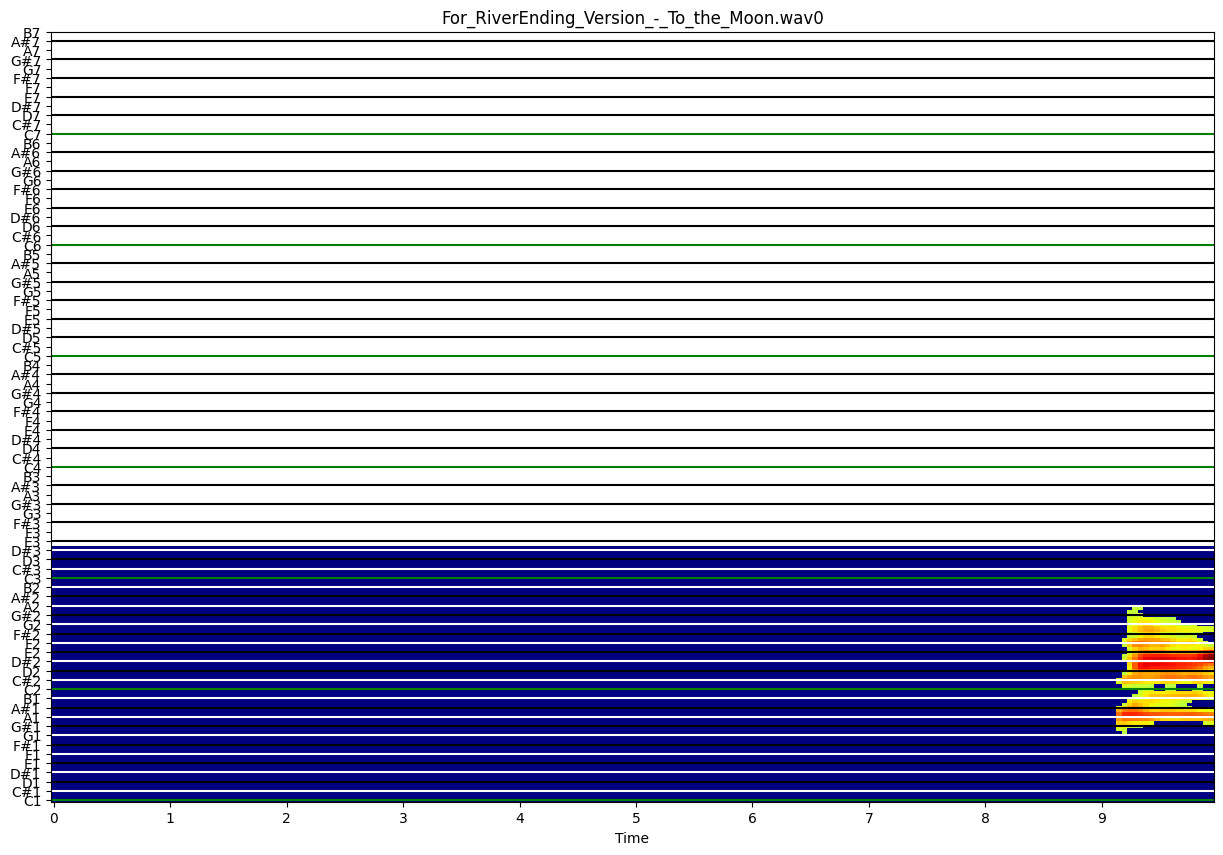

215 430
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon1 save complete


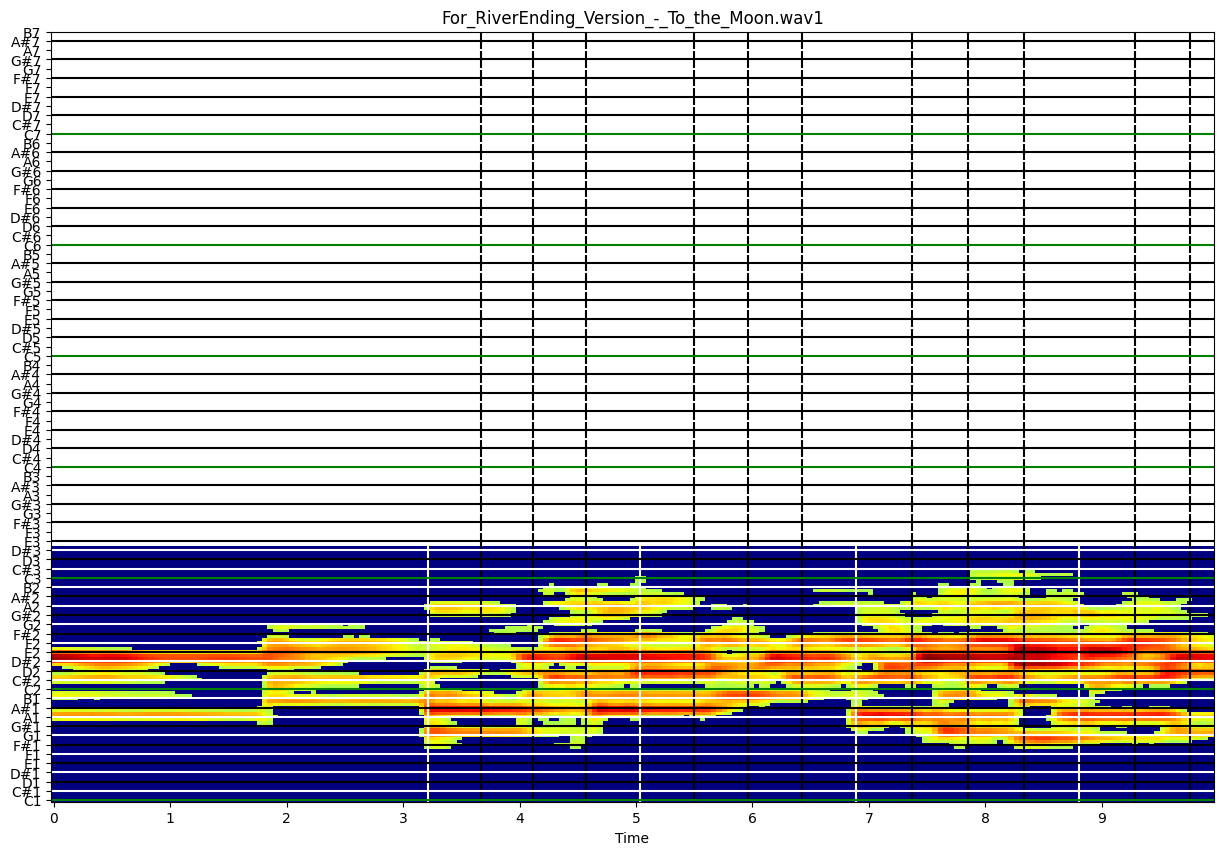

430 645
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon2 save complete


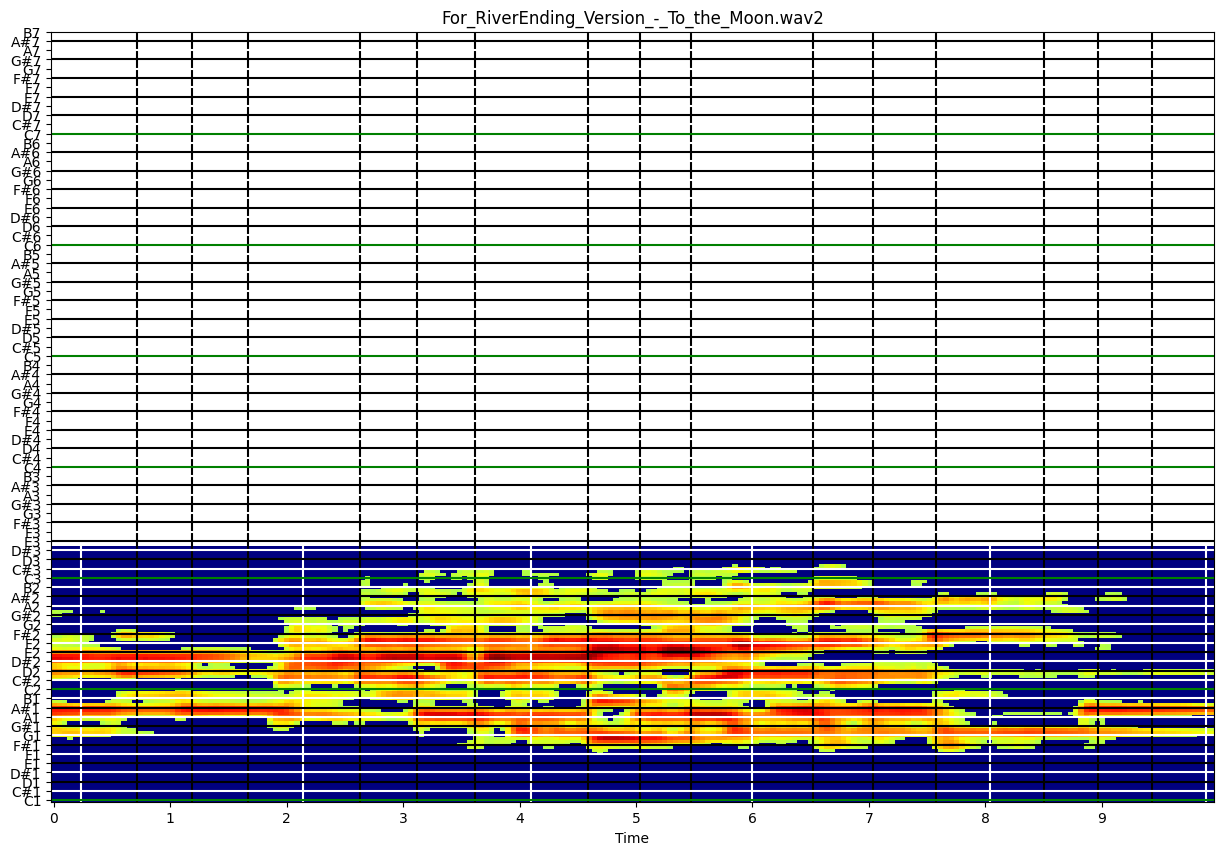

645 860
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon3 save complete


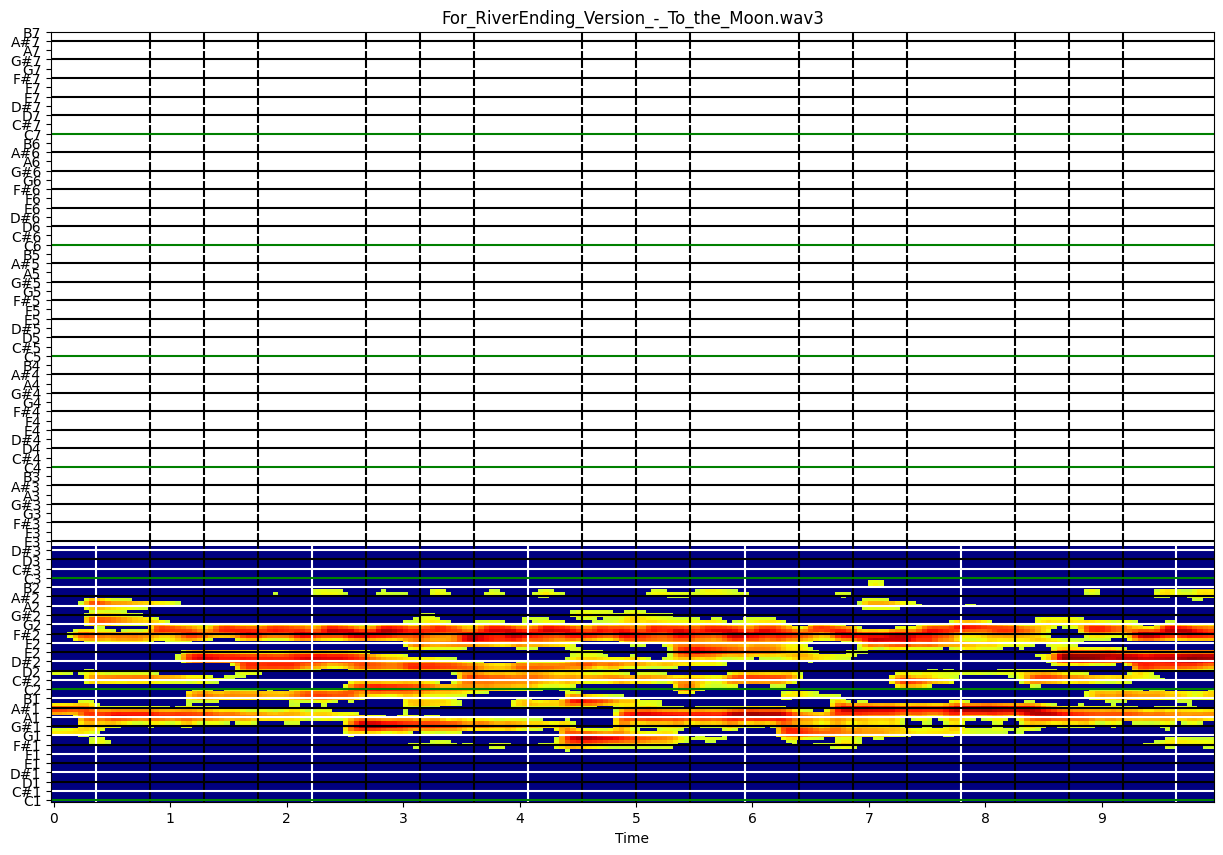

860 1075
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon4 save complete


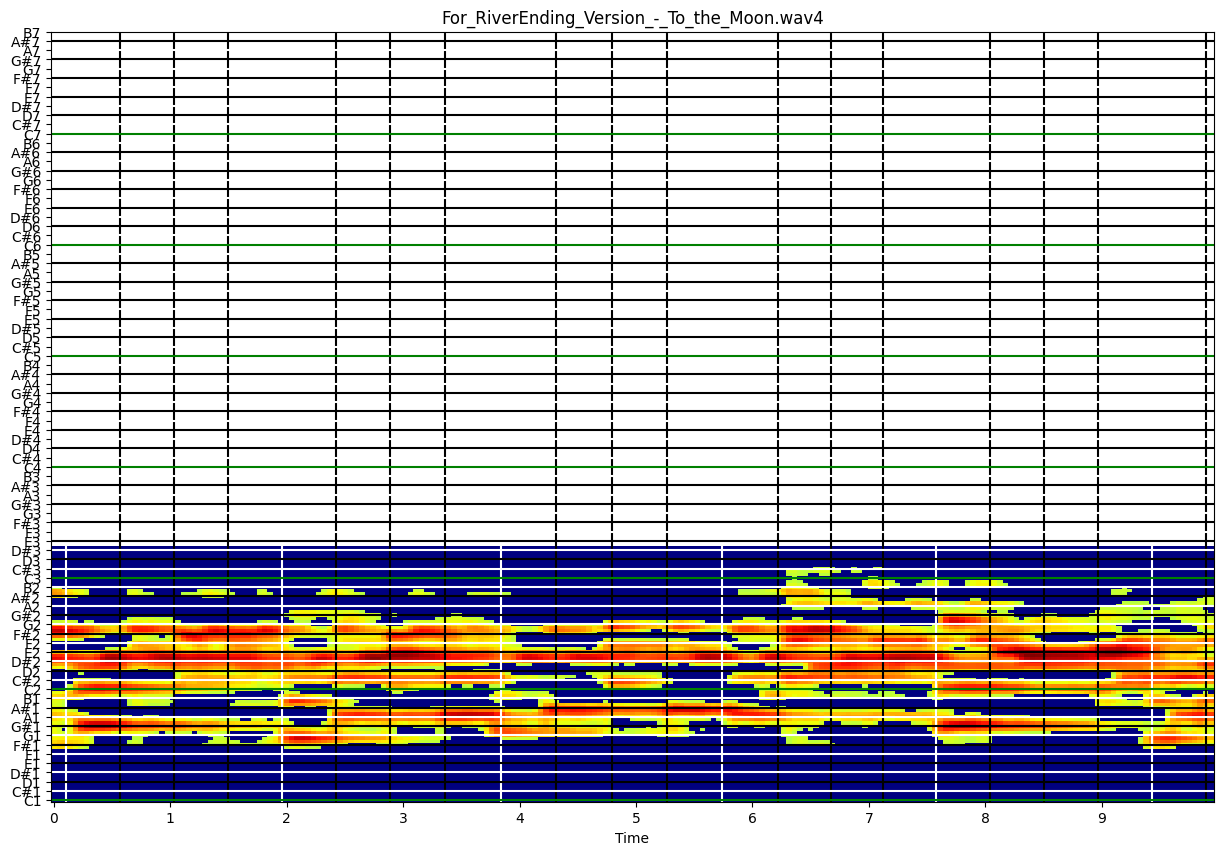

1075 1290
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon5 save complete


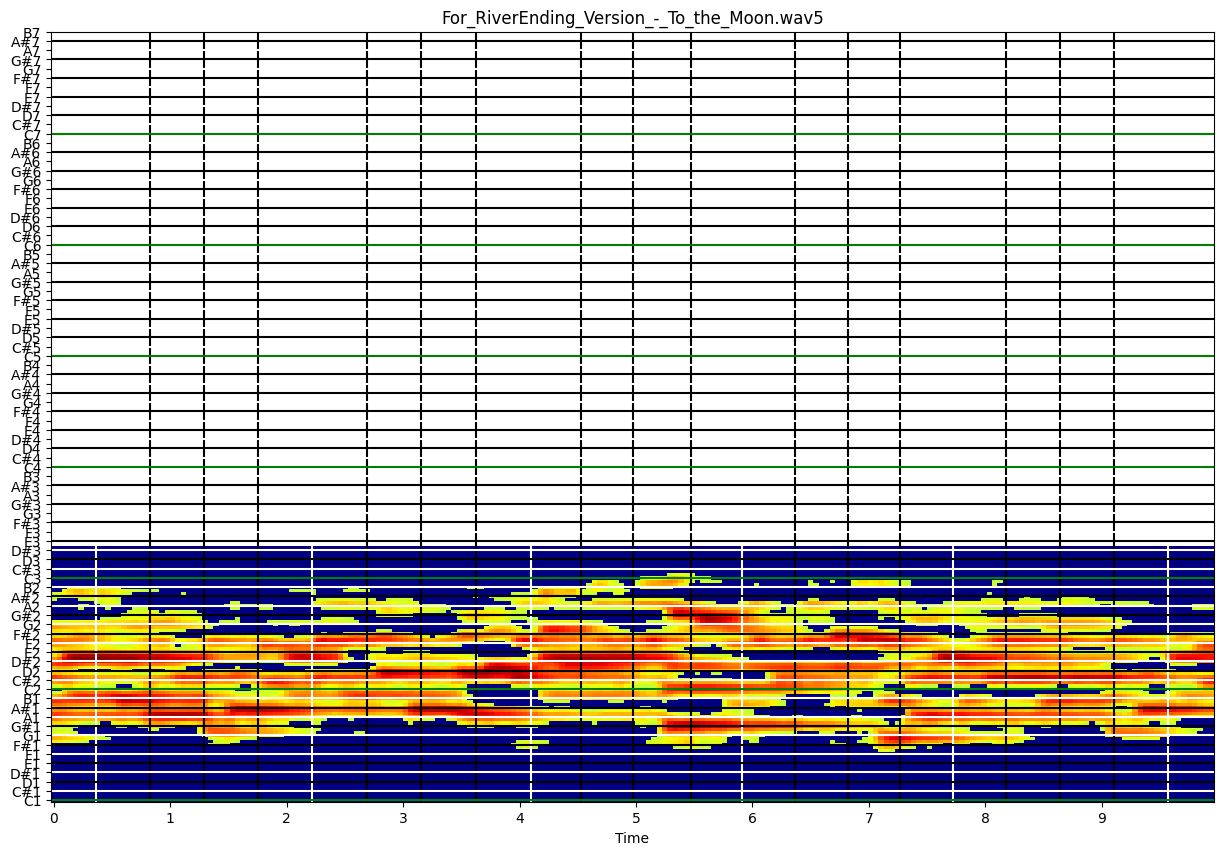

1290 1505
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon6 save complete


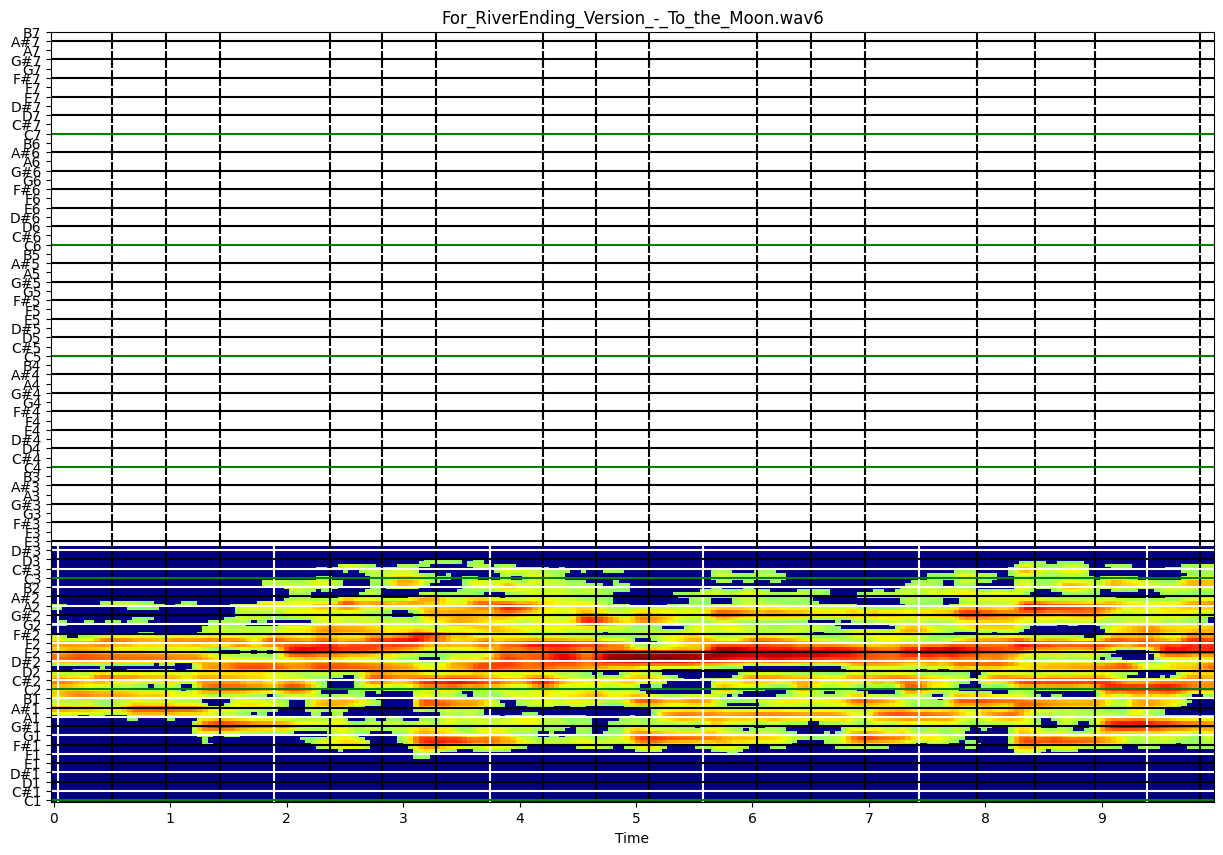

1505 1720
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon7 save complete


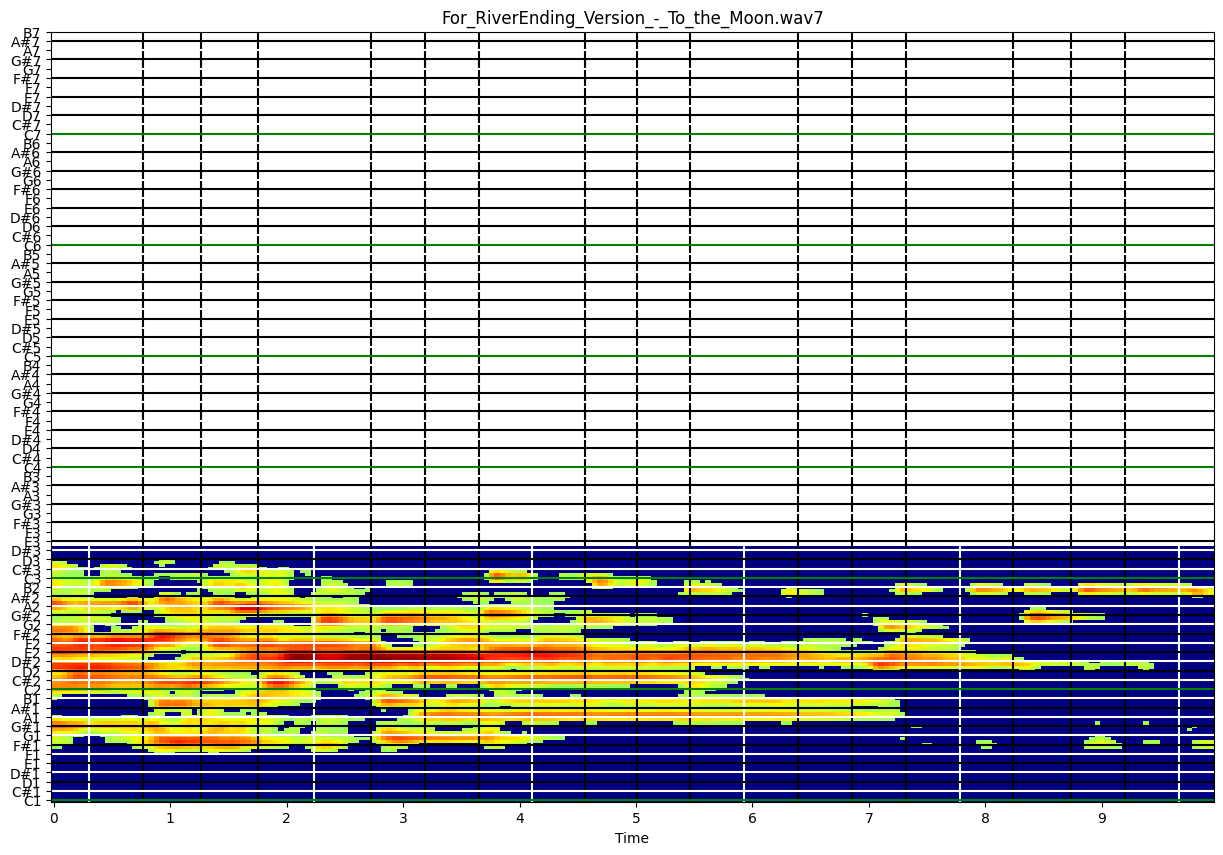

1720 1935
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon8 save complete


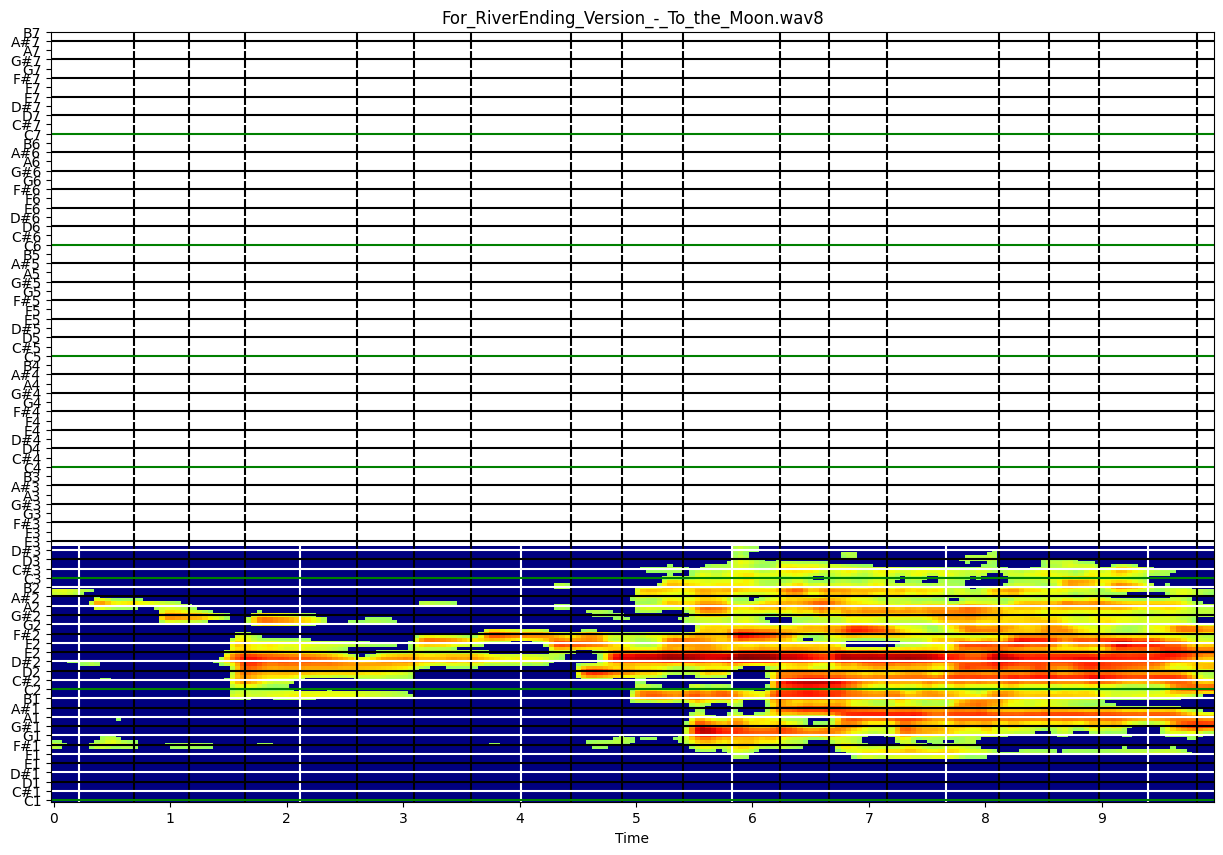

1935 2150
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon9 save complete


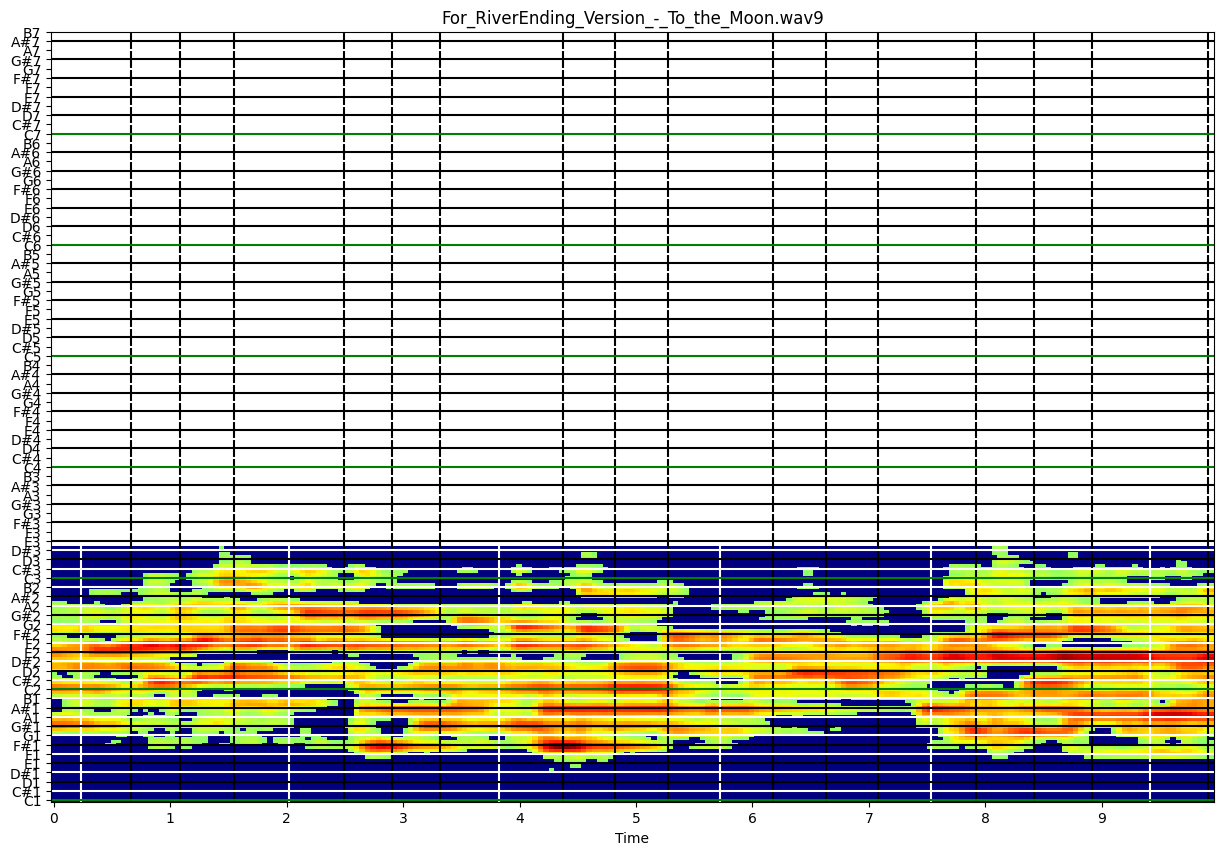

2150 2365
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon10 save complete


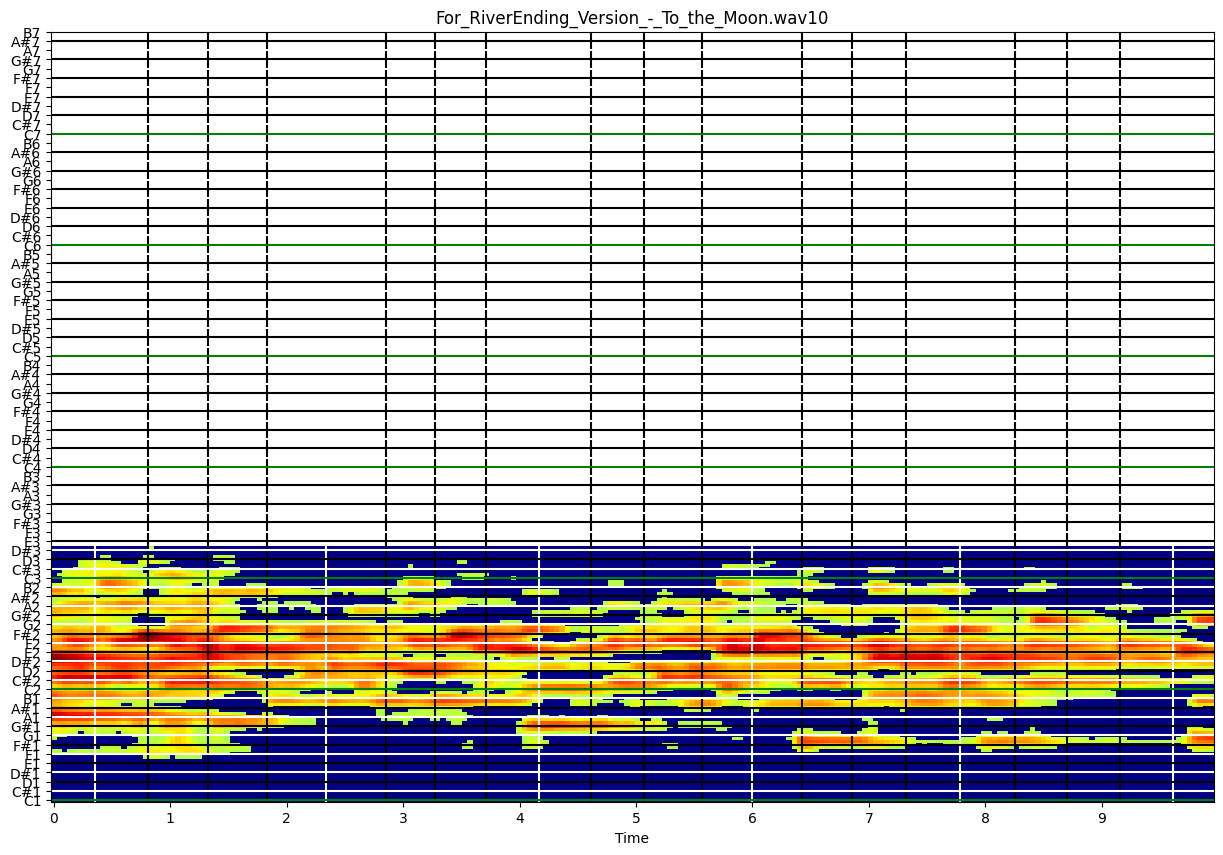

2365 2580
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon11 save complete


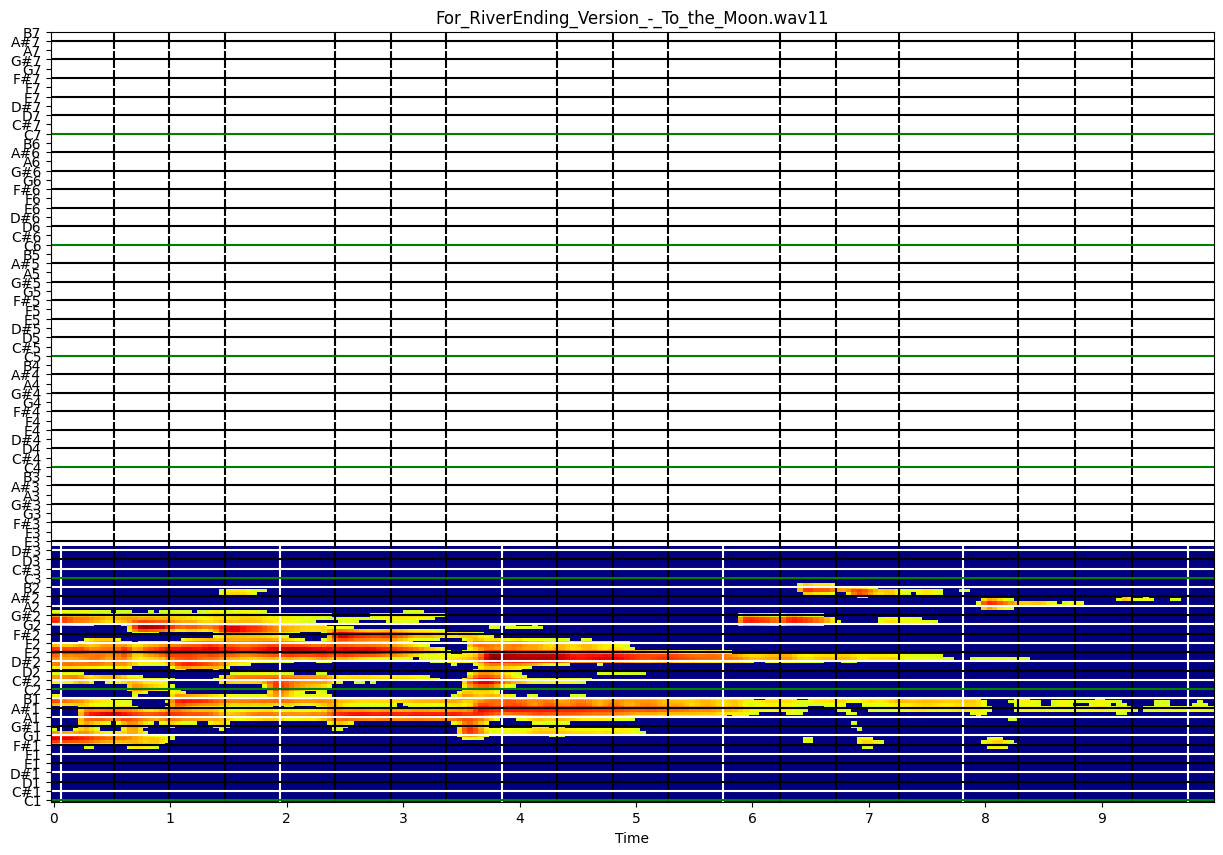

2580 2795
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon12 save complete


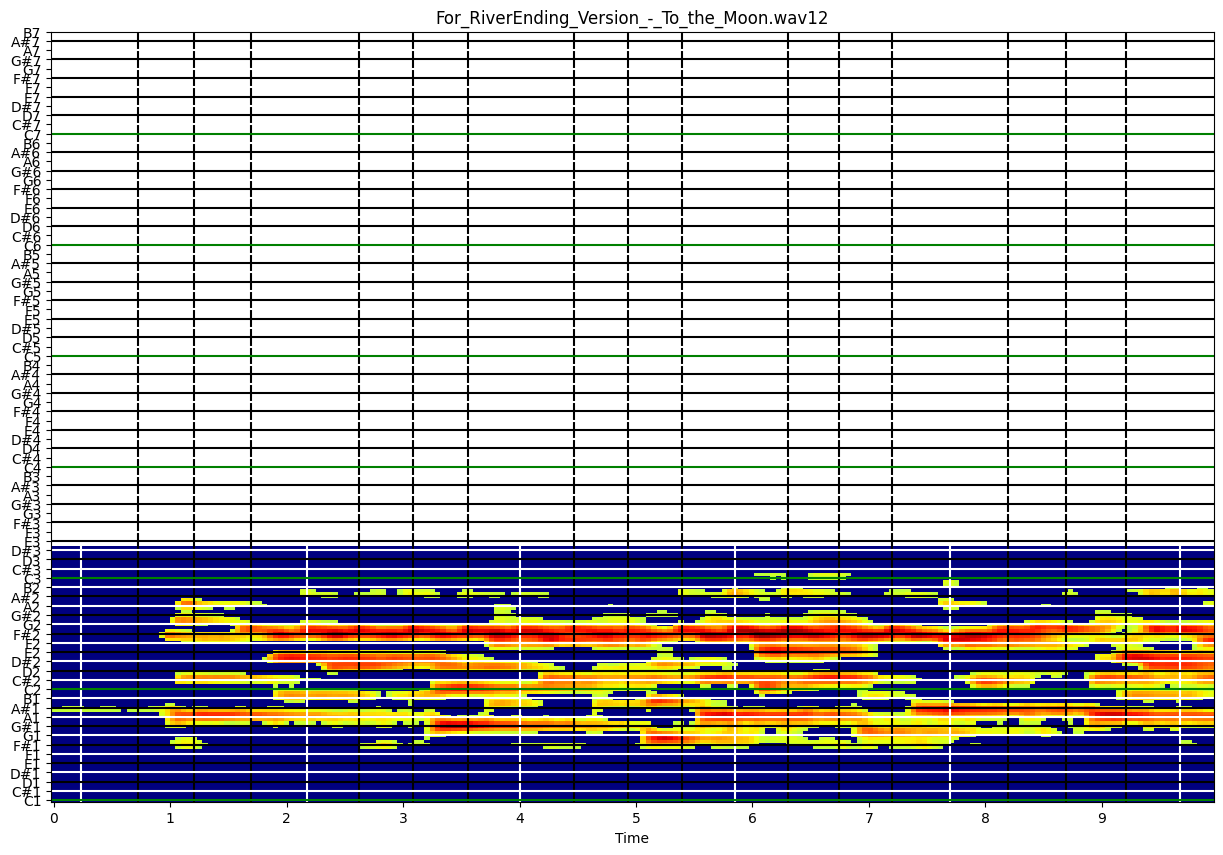

2795 3010
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon13 save complete


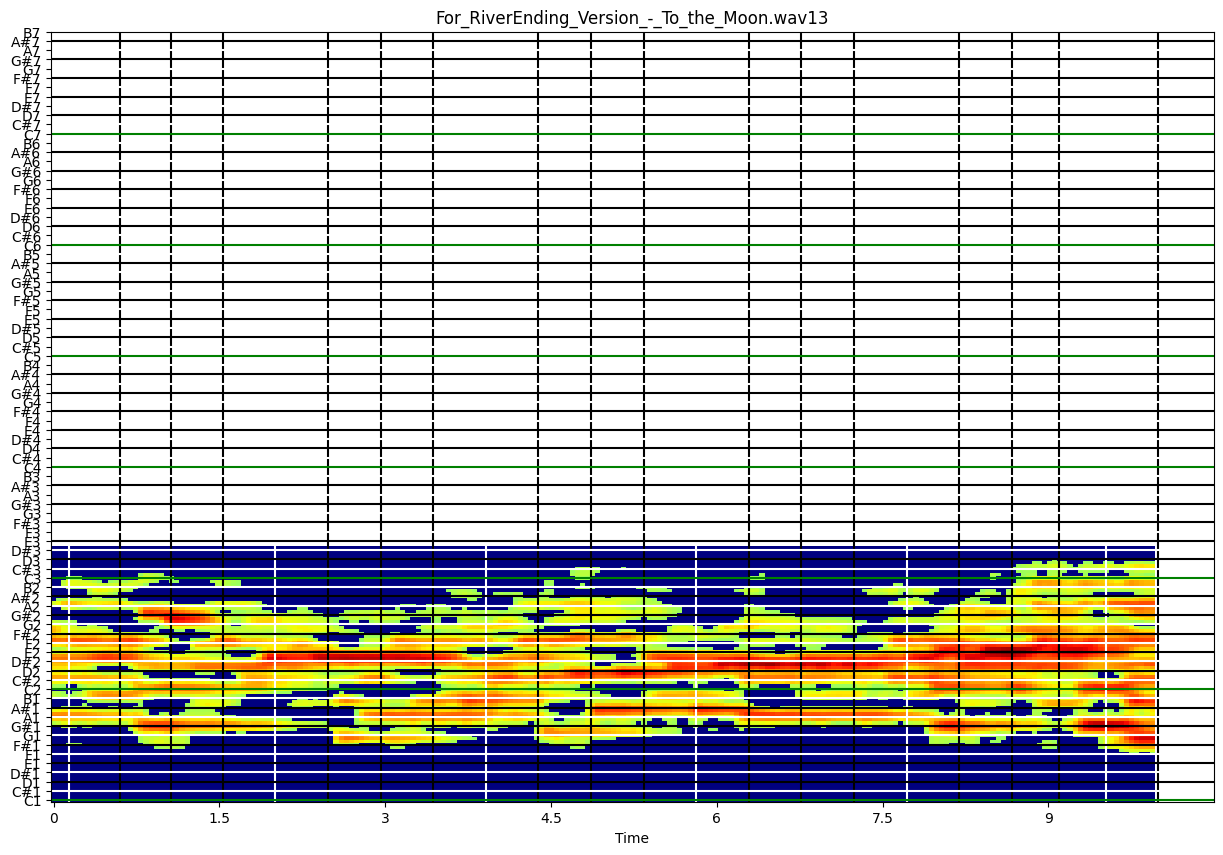

3010 3225
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon14 save complete


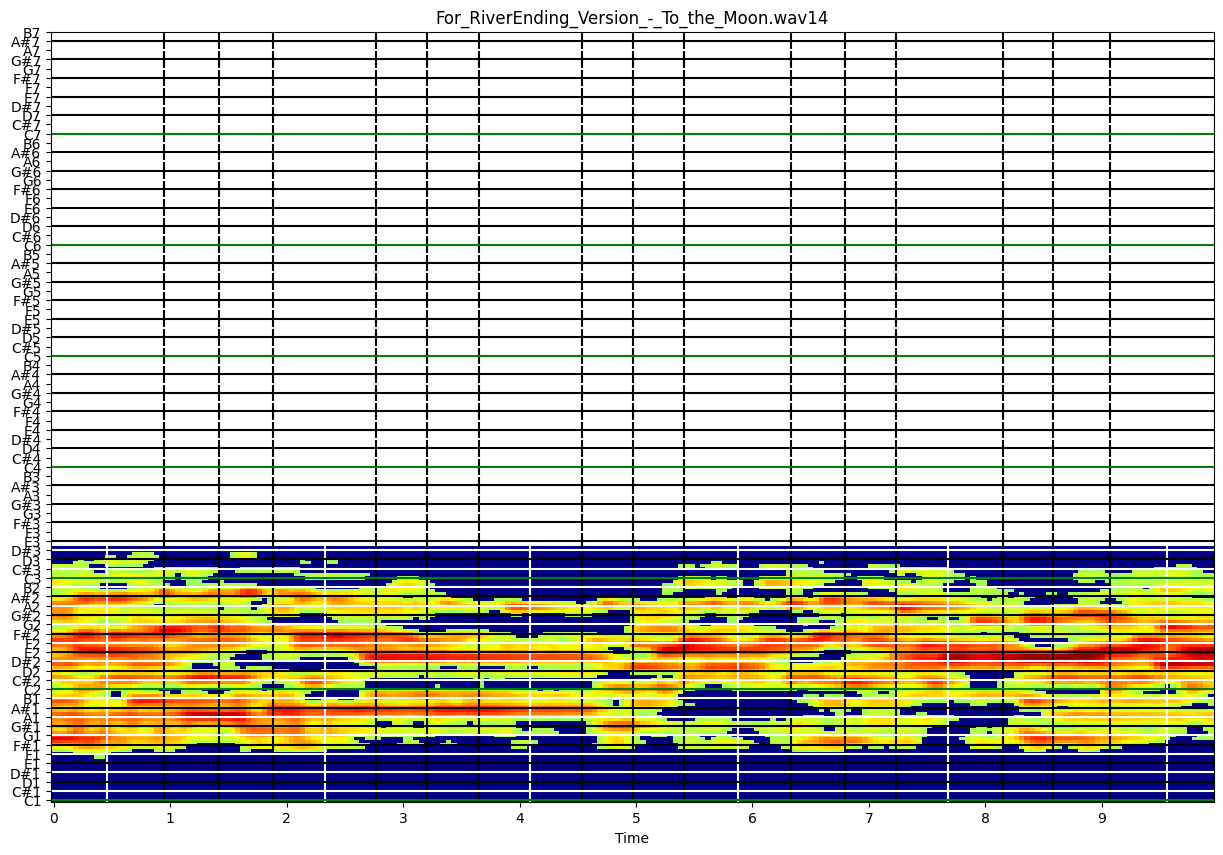

3225 3440
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon15 save complete


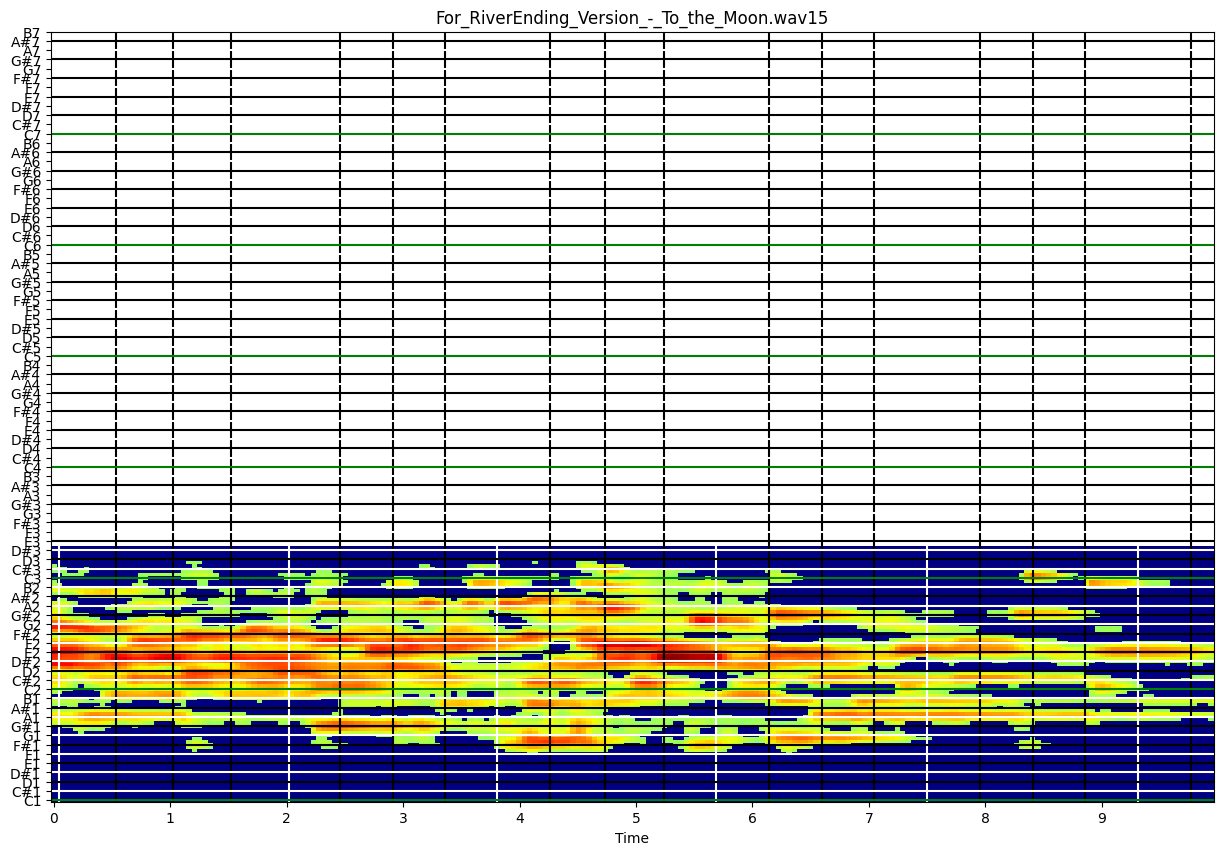

3440 3655
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon16 save complete


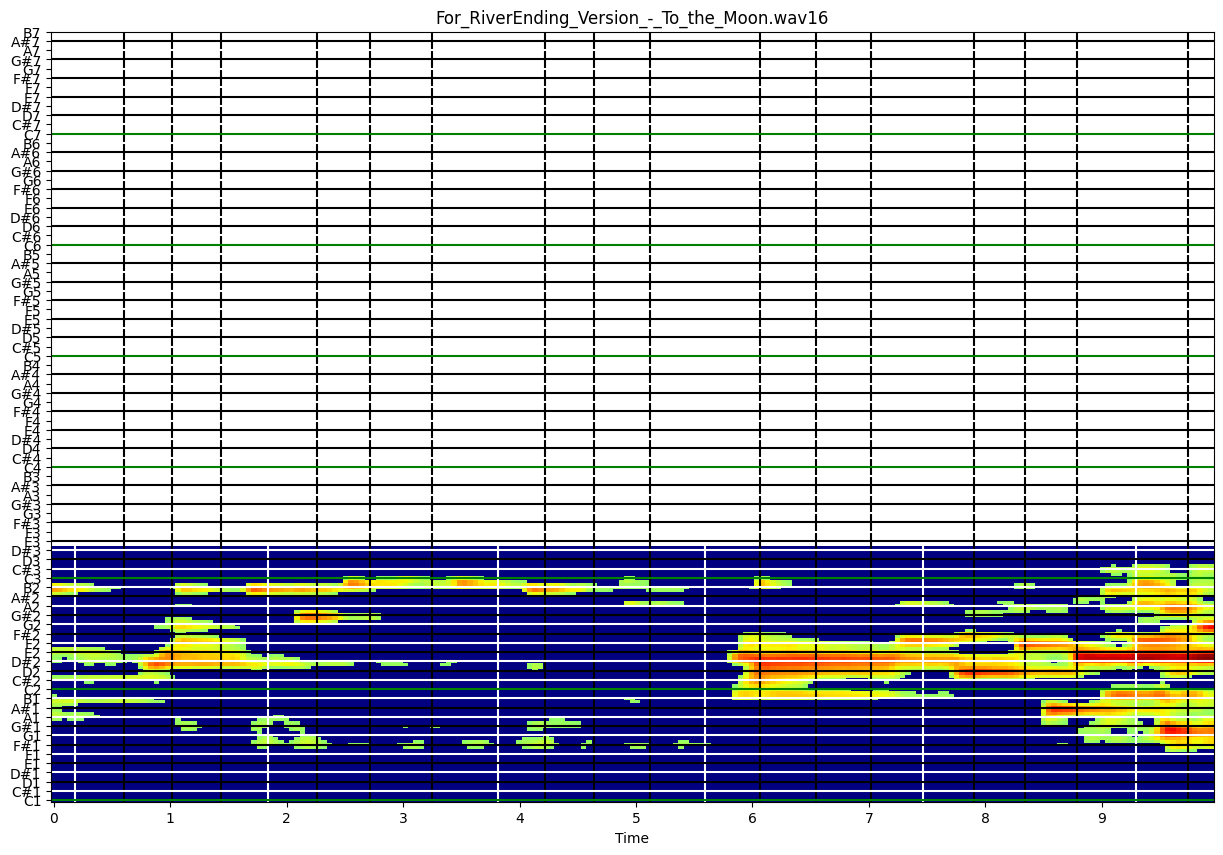

3655 3870
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon17 save complete


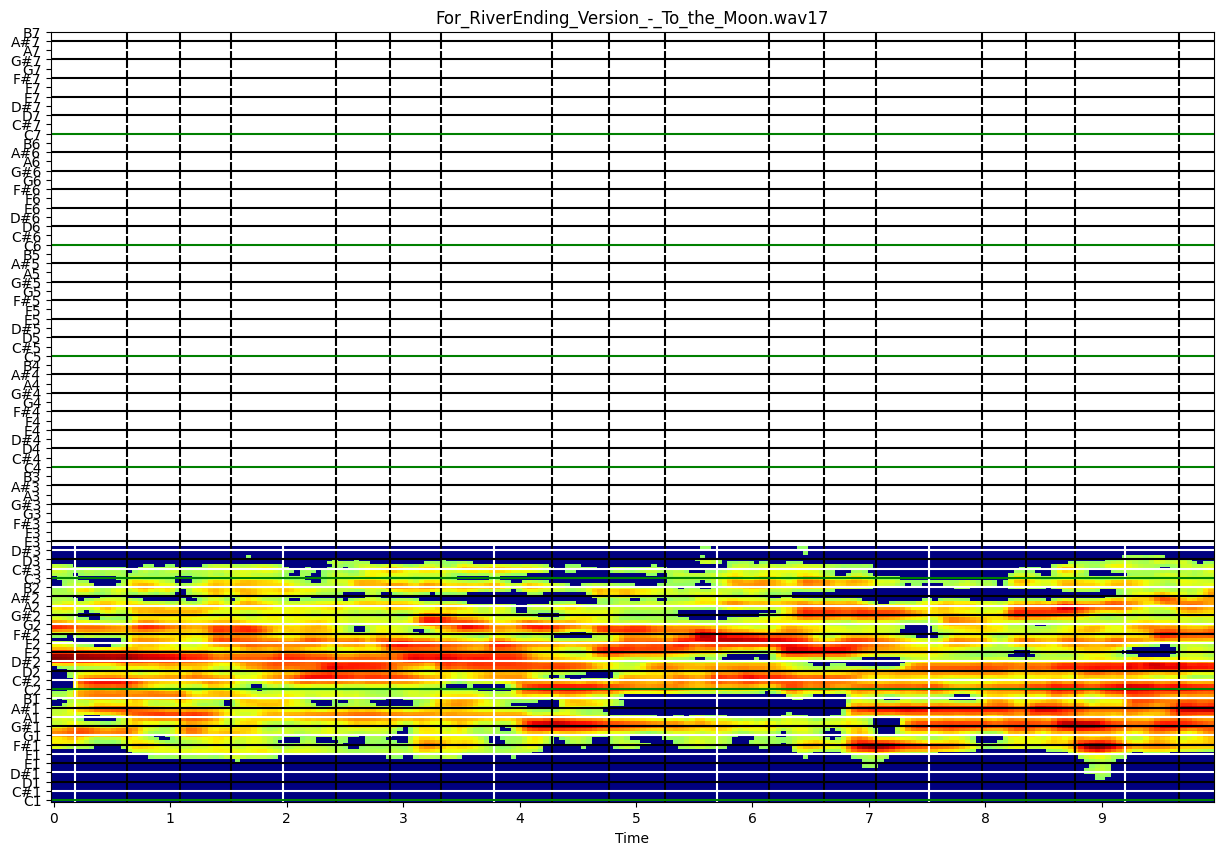

3870 4085
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon18 save complete


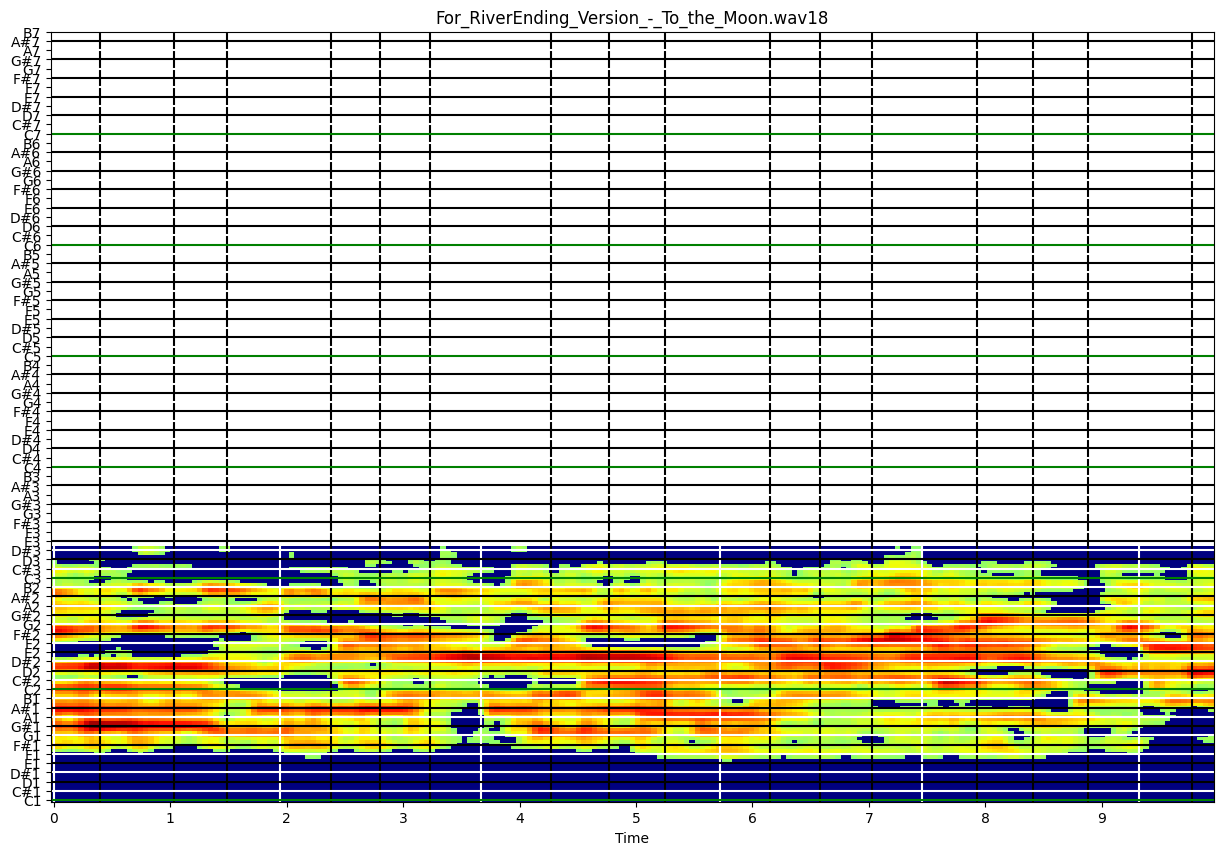

4085 4300
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon19 save complete


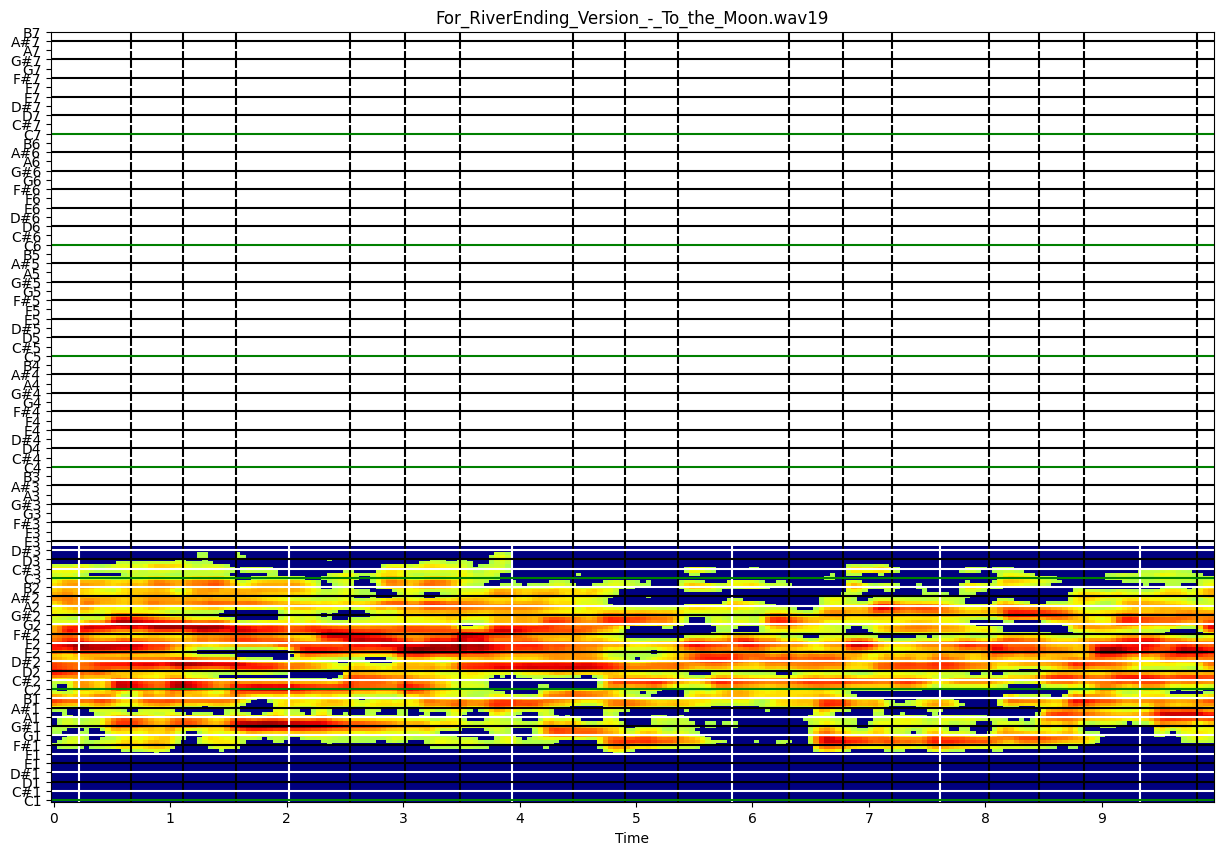

4300 4515
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon20 save complete


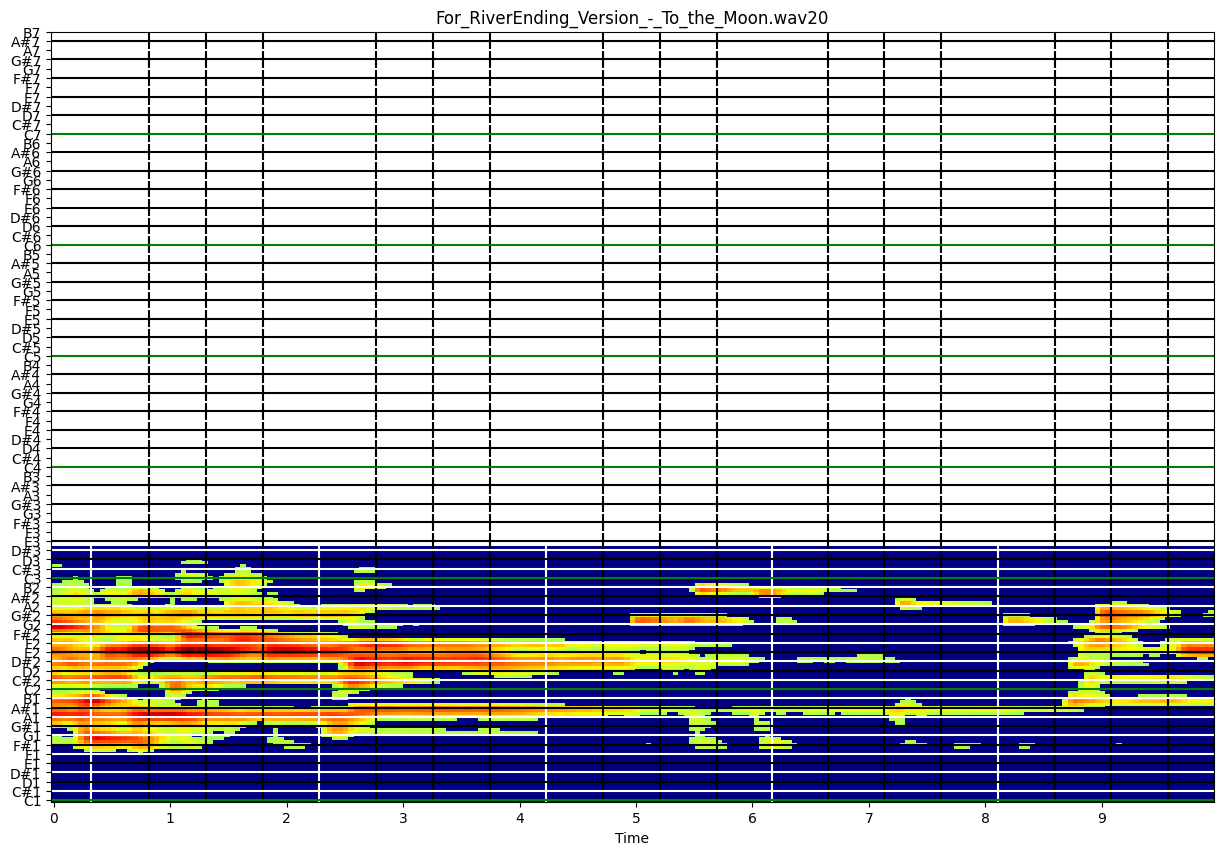

4515 4730
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
0~208 stretcing
4515 4730
92 under 0
110 under 0
119 under 0
120 under 0
0~208 stretcing
4515 4730
92 under 0
110 under 0
119 under 0
120 under 0
For_RiverEnding_Version_-_To_the_Moon21 save complete


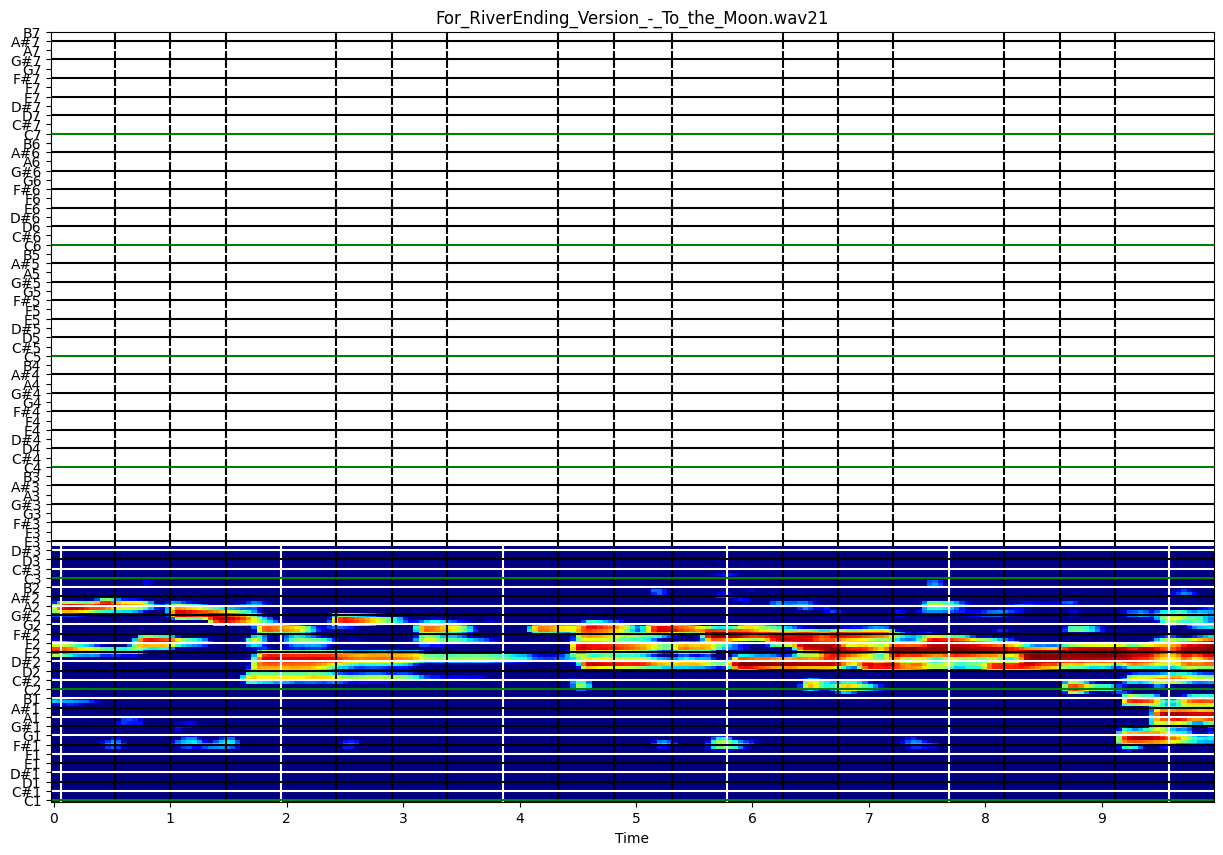

4730 4945
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon22 save complete


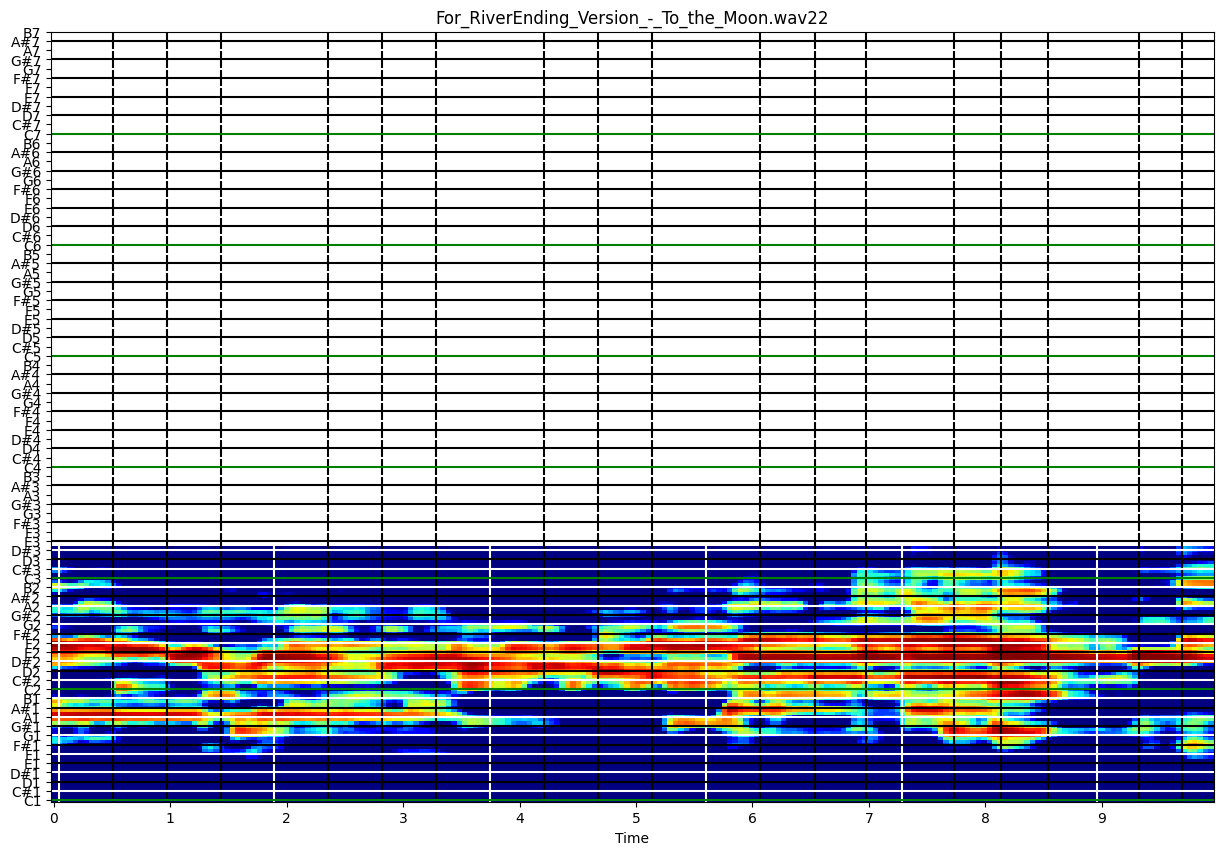

4945 5160
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon23 save complete


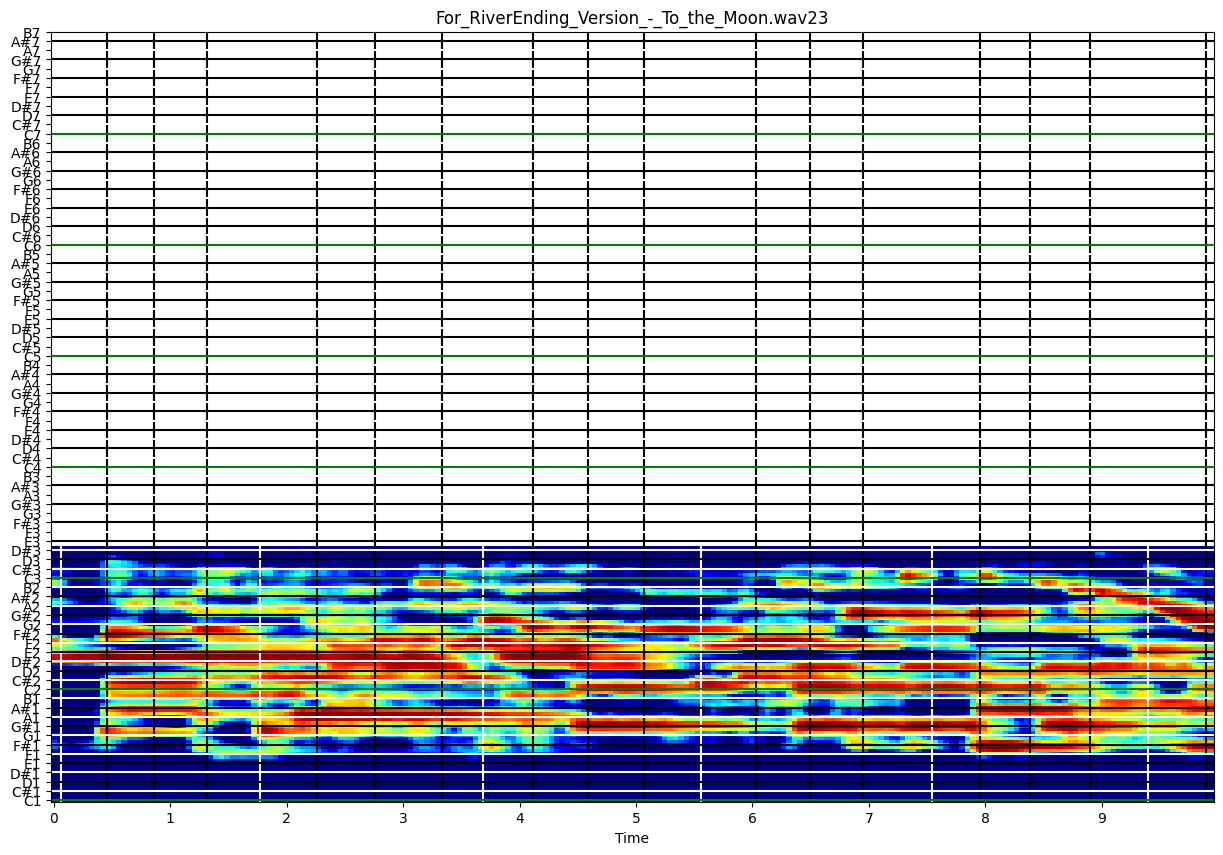

5160 5375
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon24 save complete


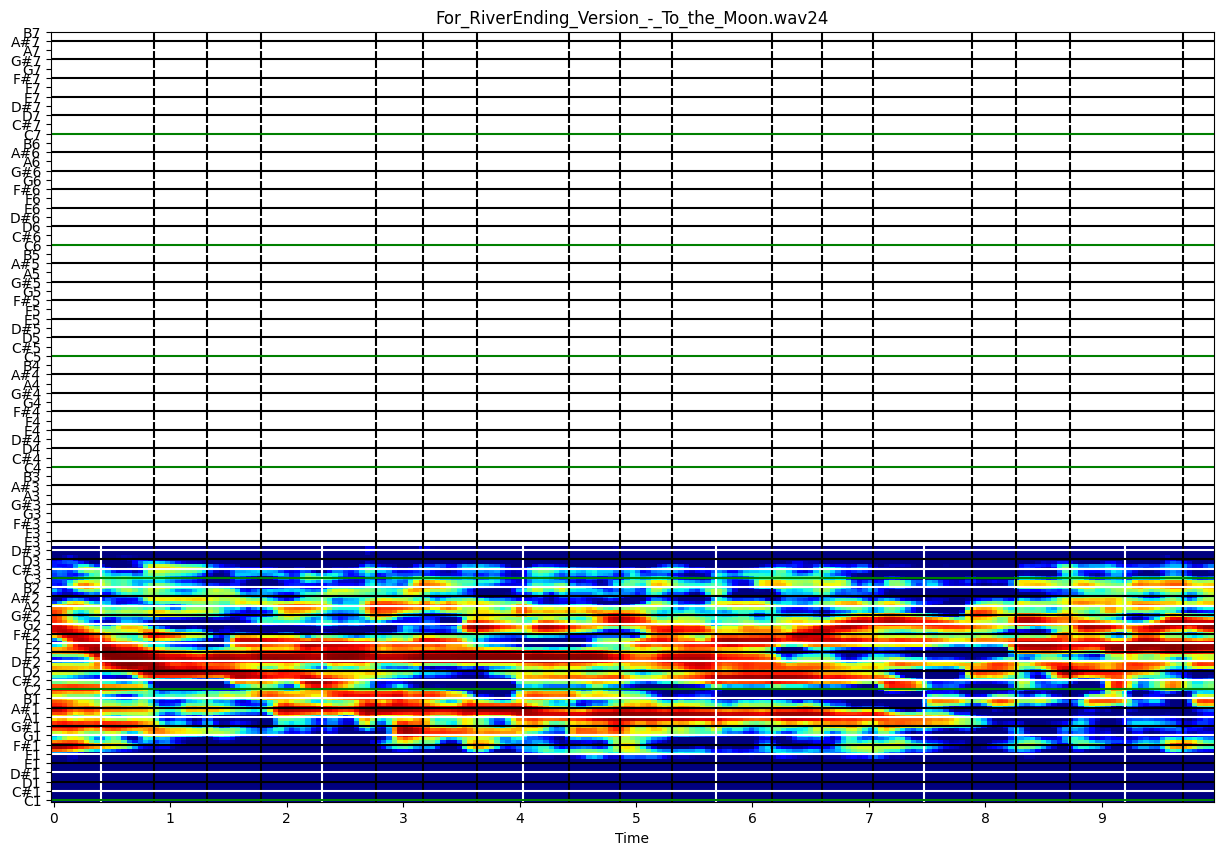

5375 5590
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon25 save complete


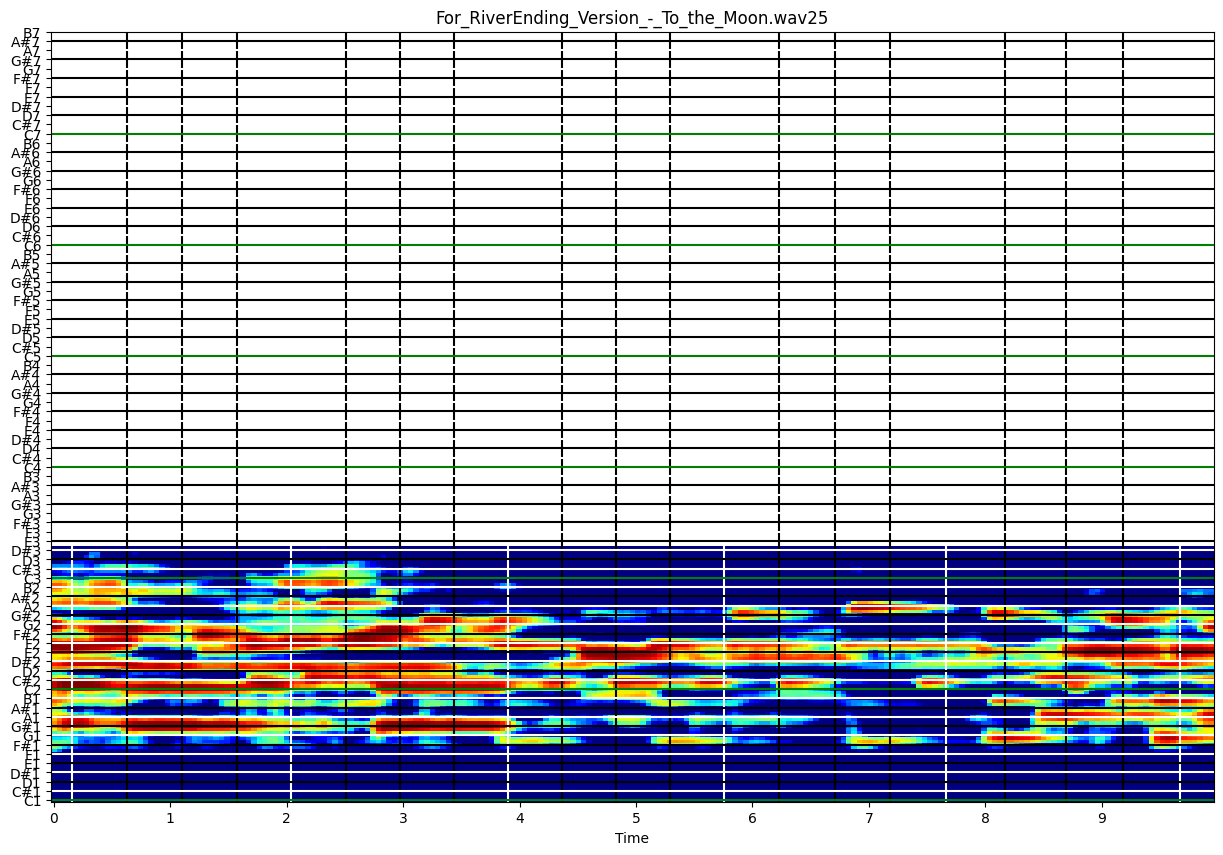

5590 5805
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon26 save complete


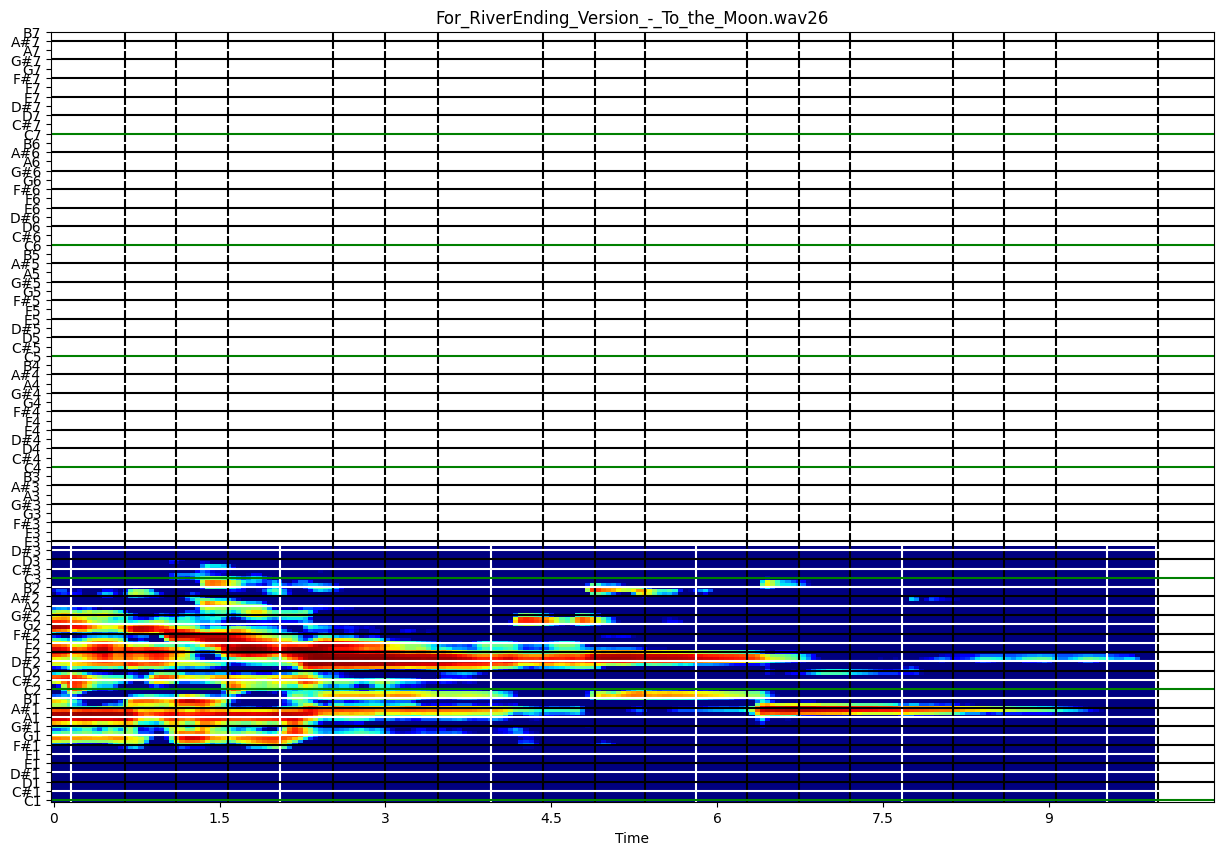

5805 6020
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon27 save complete


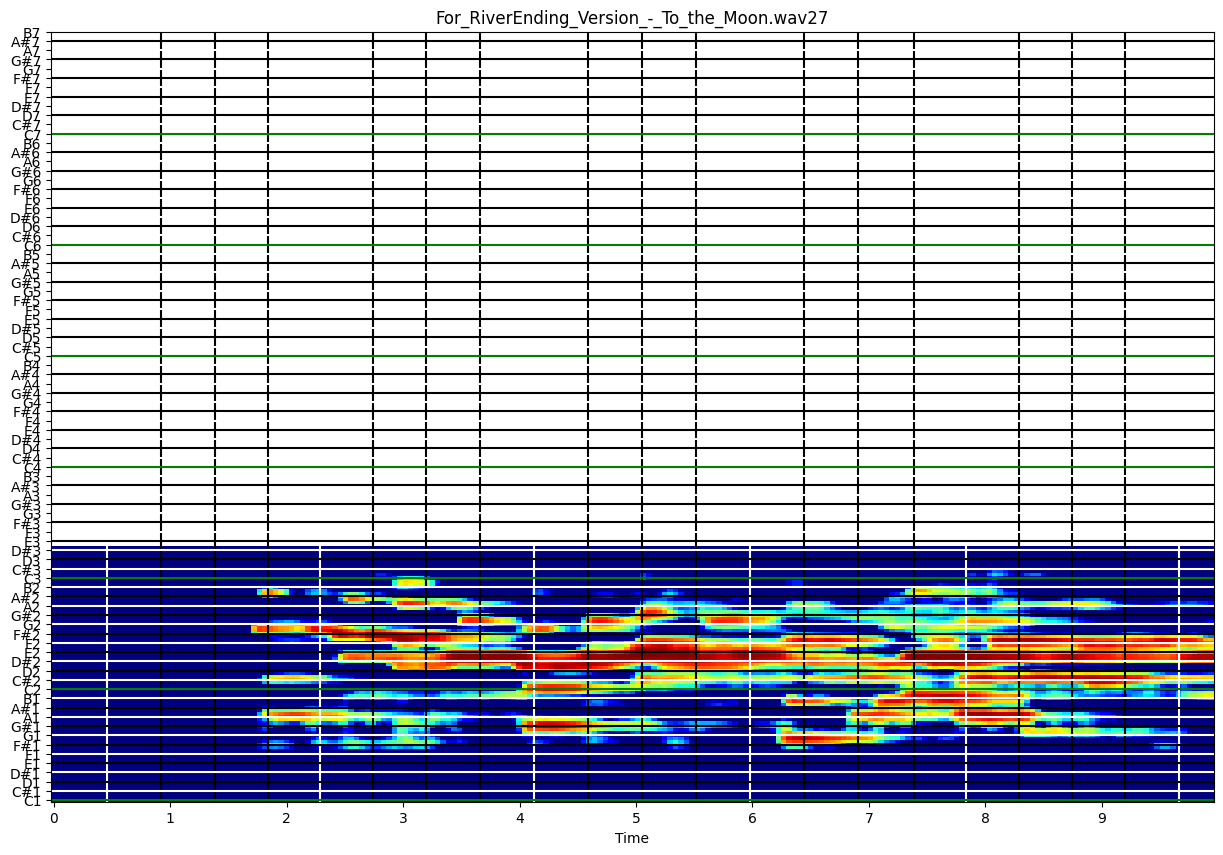

6020 6235
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon28 save complete


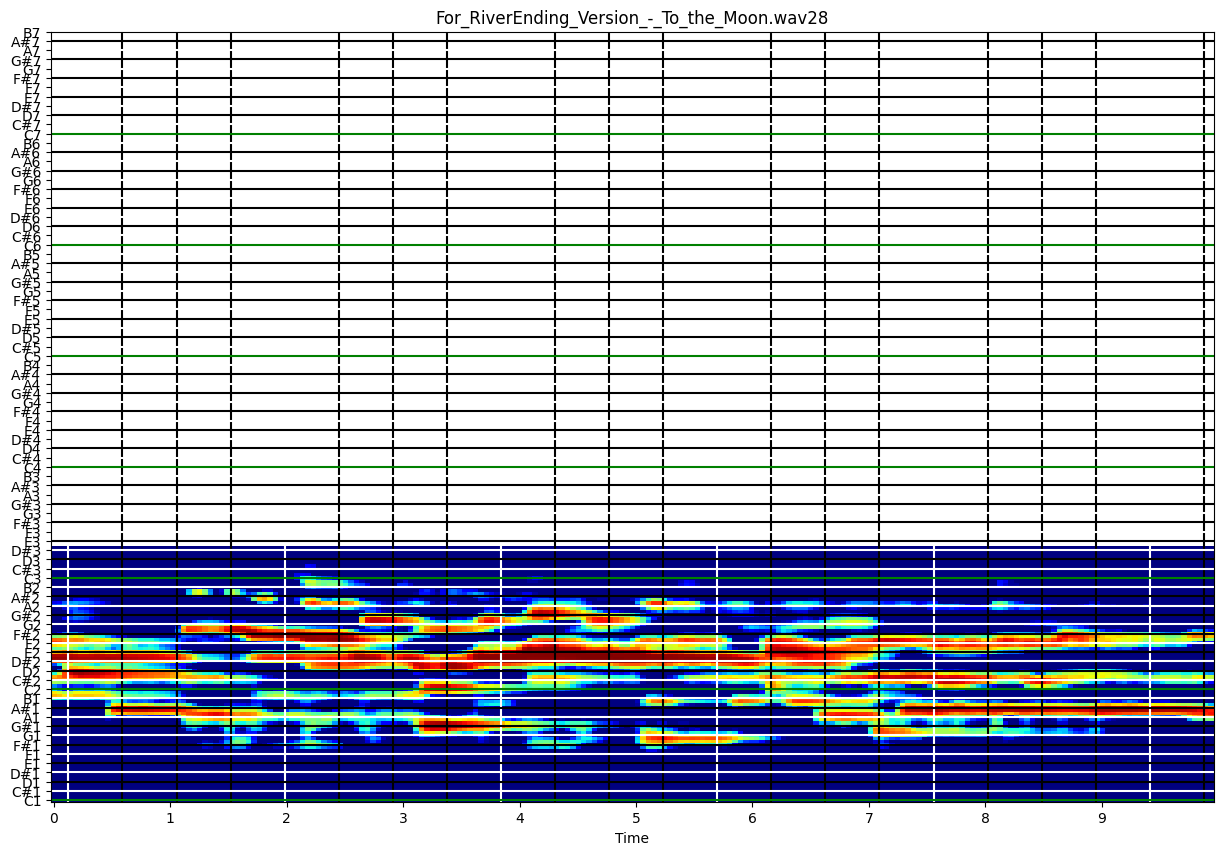

6235 6450
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon29 save complete


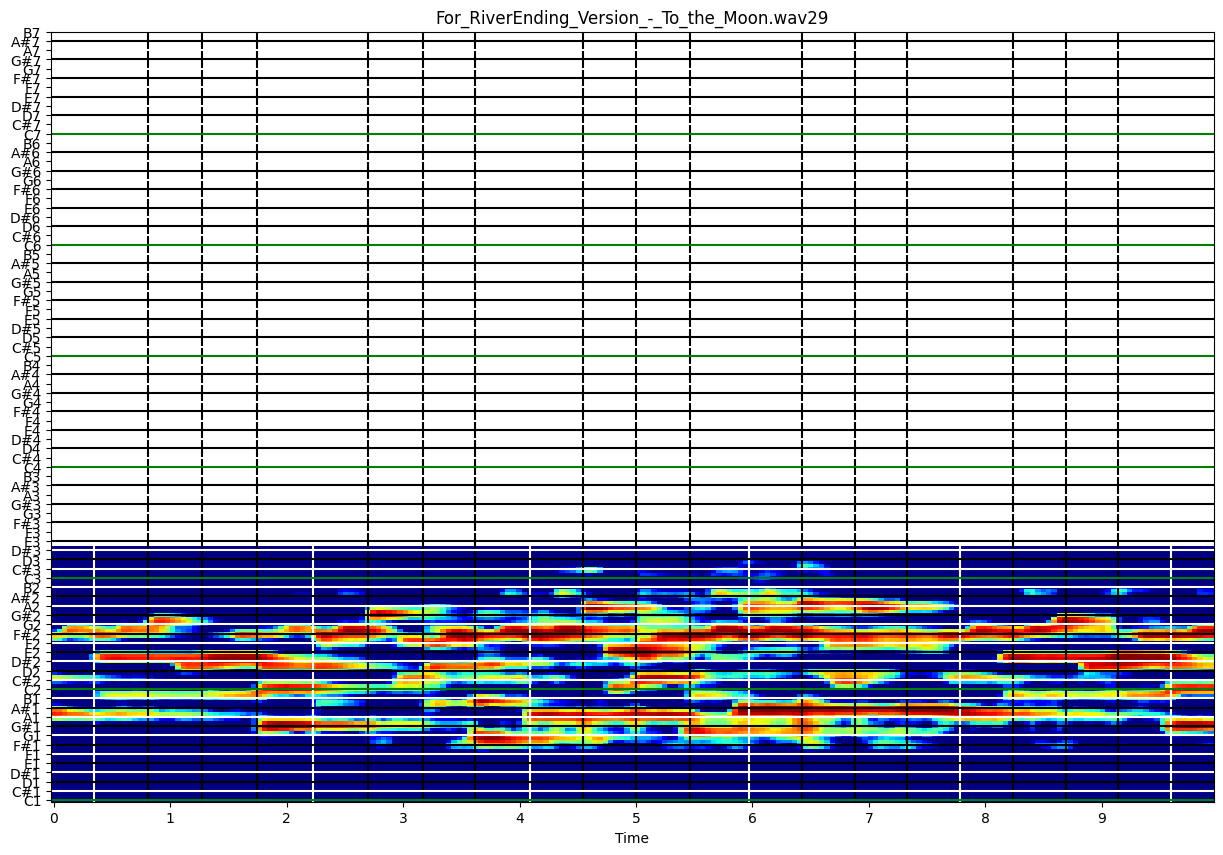

6450 6665
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon30 save complete


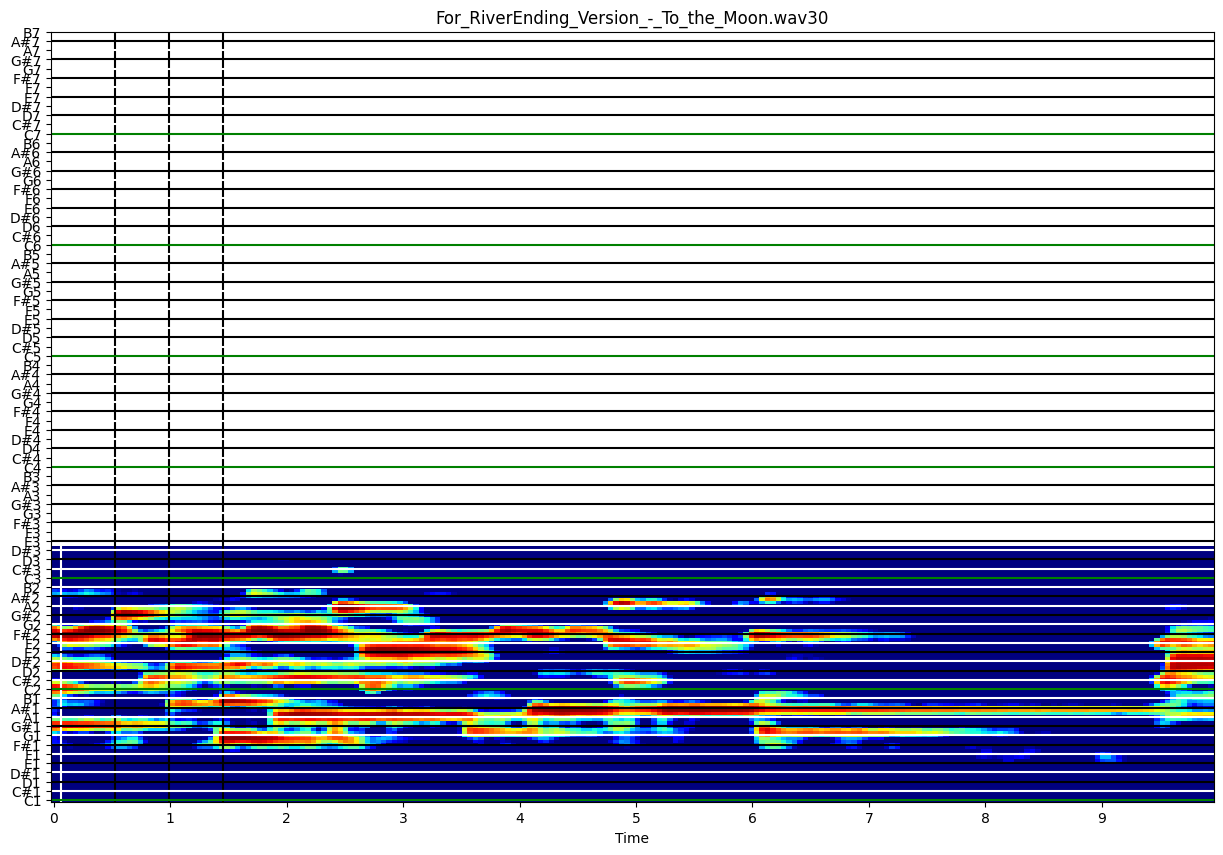

6665 6880
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon31 save complete


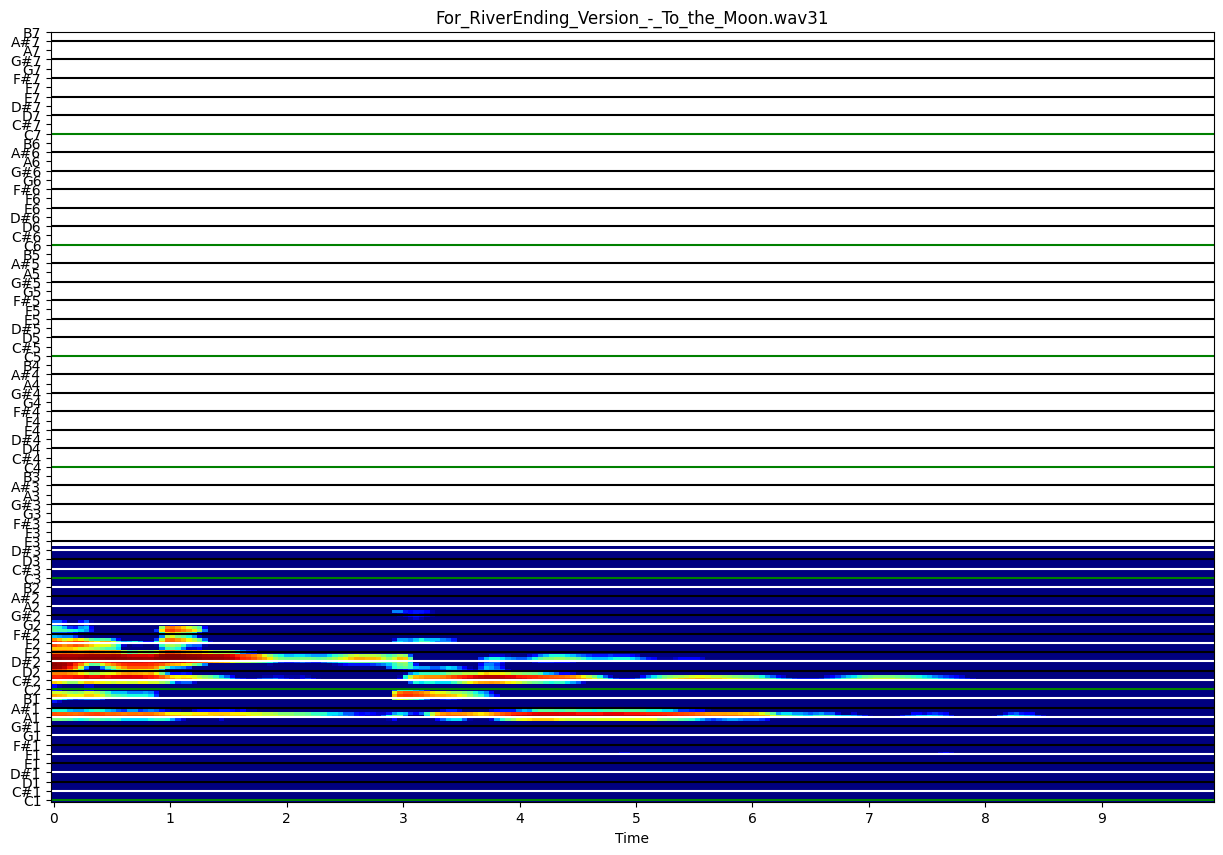

6880 7066
auto repeat start
92 under 0
110 under 0
119 under 0
120 under 0
auto repeat end
For_RiverEnding_Version_-_To_the_Moon32 save complete


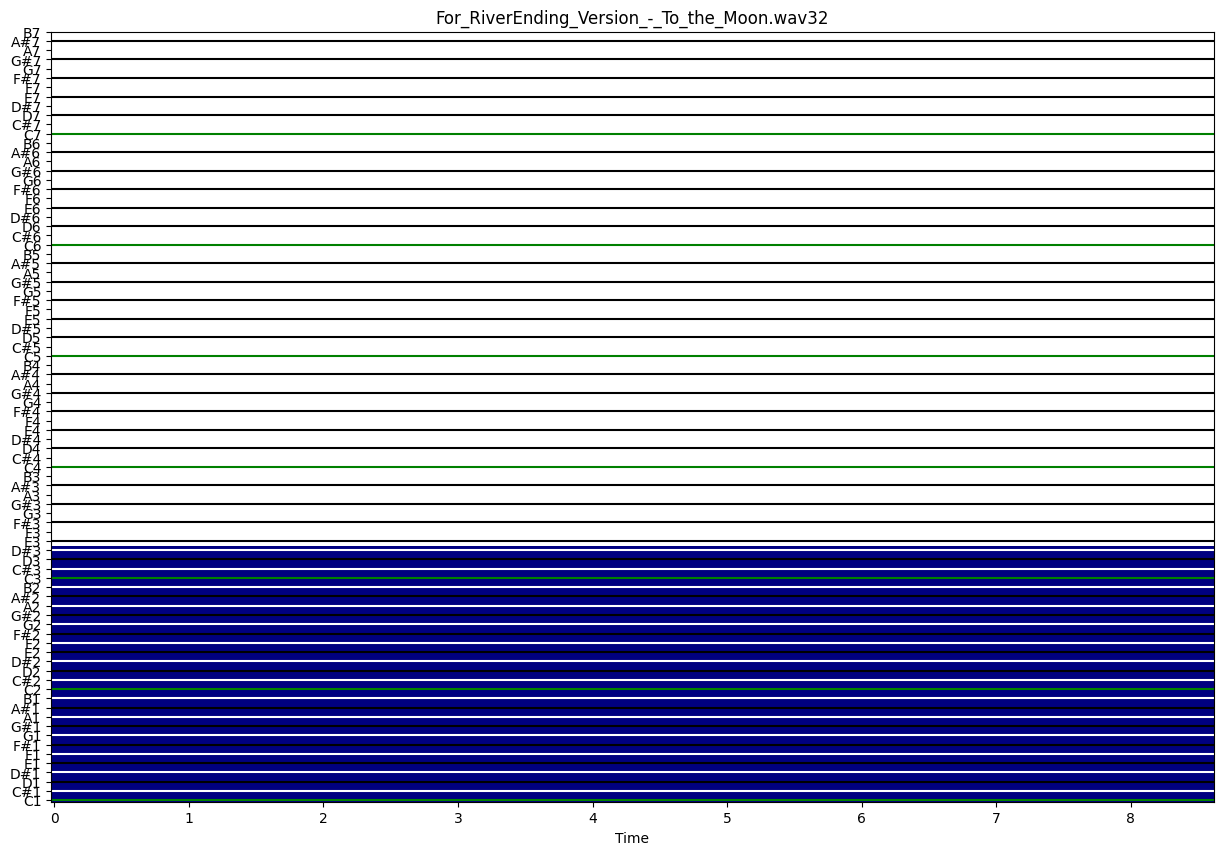

In [70]:
def mouse_eraser(event, x,y, flags, params):
    global crop
    pos = cv2.getTrackbarPos('base_level','spectrum')
    
    if event==cv2.EVENT_MOUSEMOVE:
        canvas = cv2.flip(crop, 0)
        cv2.circle(canvas,(x,y),pos//25,255,2,cv2.LINE_AA)
        img_bgr = jet(canvas)
        cv2.imshow("spectrum", img_bgr)
        
    if flags & cv2.EVENT_FLAG_LBUTTON:
        canvas = cv2.flip(crop, 0)
        cv2.circle(canvas,(x,y),pos//25,0,-1,cv2.LINE_AA)
        img_bgr = jet(canvas)
        cv2.imshow("spectrum", img_bgr)
        crop = cv2.flip(canvas, 0)

src = c_db_src.copy()

cv2.namedWindow('spectrum', cv2.WINDOW_NORMAL)
cv2.createTrackbar('base_level','spectrum',0,255,nothing)
cv2.setMouseCallback('spectrum', mouse_eraser)

global crop

fn_log = []
idx = 0
sec = 10
magin = 0

idxlist = mk_sec_idxlist(src,sec,sr=sr,hop_length=hop_len)
crop = cqt_load(src,idxlist[idx])

while True:
    hist = cv2.calcHist([crop], [0], None, [256], [1, 257])
    histImg = getGrayHistImage(hist)
    cv2.imshow('histogram', histImg)
    
    img_bgr = cv2.flip(jet(crop),0)
    cv2.imshow('spectrum', img_bgr)
        
    kw=cv2.waitKey()
    pos = cv2.getTrackbarPos('base_level','spectrum')
    
    if kw==27:
        break
    elif kw==ord('r'):
        crop = cqt_load(src,idxlist[idx])
        fn_log.clear()
        print()
        print('-'*10)
        print("Reset")
        print('-'*10)
        print()
    elif kw==ord('z'):
        if fn_log == []:
            print("nothing log")
        else:
            fn_log.pop()
            crop = cqt_load(src,idxlist[idx])
            crop = auto_fn(crop,fn_log)
    elif iskw(kw):
        crop, fn_log = kw_fn(kw,crop,pos,fn_log)
    elif kw==ord('a'):
        print("auto repeat start")
        if fn_log==[]:
            print('nothing log')
        else:
            crop = auto_fn(crop,fn_log)
        print("auto repeat end")
    elif kw==ord('n'):
        idx +=1
        if idx >= len(idxlist):
            idx -=1
            print('end index')
        crop = cqt_load(src,idxlist[idx])
    elif kw==ord('b'):
        idx -=1
        if idx < 0:
            idx = 0
            print('start index')
        crop = cqt_load(src,idxlist[idx])
    elif kw==ord('s'):
        beat_time_list = beat_times[(sec*idx < beat_times)&(beat_times < sec*(idx+1))] - sec*idx
        notes = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
        y_ticks = np.arange(0,12*freq_w*octave,freq_w)
        y_list=[]

        for o in range(octave):
            for i in range(12):
                y_list.append(notes[i]+'%d'%(o+1))

        plt.style.use('default')
        fig, ax = plt.subplots(1,1,figsize=(15,10))
        img = librosa.display.specshow(crop, sr=sr, x_axis='time', ax=ax, hop_length= hop_len, bins_per_octave= 12*freq_w,
                                    cmap='jet'
                                    )
        ax.set(title=filename+str(idx))
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_list)
        
        for i,v in zip(range(len(beat_time_list)),beat_time_list):
            if i % 4==0:
                ax.axvline(v,c='white')
            else:
                ax.axvline(v,c='k')
                
        for i in np.arange(0,12*freq_w*octave,freq_w):
            if i % (freq_w*12) ==0:
                ax.axhline(i,c='g')
            elif i % (freq_w*2) ==0:
                ax.axhline(i,c='k')
            else:
                ax.axhline(i,c='white')
            
        plt.savefig('./output/'+filename.split('.')[0]+str(idx))
        print(filename.split('.')[0]+str(idx),'save complete')
        plt.show()
        
        src[:,idxlist[idx][0]:idxlist[idx][1]] = crop.copy()
    
    else:
        continue
            

cv2.destroyAllWindows();

In [71]:
# c_signed = np.where(C!=0,C/np.abs(C),0.)
_, mask = cv2.threshold(src,50,1, cv2.THRESH_BINARY)
print(mask.shape)
print(mask.min(),mask.max())

(83, 7066)
0 1


In [72]:
icqt_src = np.where(mask,C,C/2)
print(icqt_src.shape)
print(icqt_src.min(),icqt_src.max())

(83, 7066)
(-6.469502+0.68222654j) (6.2468834+0.21574771j)


In [73]:
y = librosa.icqt(C= icqt_src, sr= sr, hop_length= hop_len, fmin=min_midi)
# sf.write('./output/icqt.wav',y,sr,"PCM_24")

In [74]:
from cqt_to_piano_roll import cqt_to_piano_roll
from piano_roll_to_pretty_midi import piano_roll_to_pretty_midi

In [75]:
threshold = 10

# y, sr = librosa.load('./output/icqt.wav')

# cqt = librosa.cqt(y, sr=sr, fmin=min_midi, n_bins=max_midi - min_midi)
pr = cqt_to_piano_roll(icqt_src, min_midi, max_midi, threshold)

audio_time = len(y) / sr
fs = pr.shape[1]/audio_time
pm = piano_roll_to_pretty_midi(pr, fs=fs)
pm.write("For_RiverEnding_Version_-_To_the_Moon.mid")